# EDA for Nottingham Dataset

## Functions for preprocessing Nottigham dataset

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
import os
import re
from collections import Counter

sns.set_style("dark")
global control_var
control_var = True


def save_dataframe(df,relative_path,file_name):
    reorder_columns = df.columns.sort_values(ascending=False)
    df_to_be_saved = df[reorder_columns]
    print(file_name," dataset shape",df_to_be_saved.shape)
    print(df_to_be_saved.columns)
    print("-"*10)
    df_to_be_saved.to_pickle(f'{relative_path}/{file_name}.pkl')

def load_dataframe(relative_path,dataframe_name):
    df = pd.read_pickle(f'{relative_path}/{dataframe_name}.pkl')    
    return df

def write_tuneBook_file(df,relative_path,file_name):
    with open(f'{relative_path}/{file_name}.abc', 'w') as f:
        for song in df["clean_song"]:
            f.write(song+'\n')

def get_tuneBooks_file_names(path):
    tuneBook_filenames = []
    
    for tuneBook_name in os.listdir(path):
        if tuneBook_name.endswith('.abc'):
            tuneBook_filenames.append(tuneBook_name)
    
    #return ["jigs.abc"]
    return tuneBook_filenames
def split_abc_song(abc_song):
    k_index = abc_song.find('K:')

    split_index = abc_song.find('\n', k_index)

    header = abc_song[:split_index]
    body = abc_song[split_index+1:]
    return header, body

def tuneBook_to_dataframe(tuneBook):
    song_list = tuneBook.split("\n\n")
    song_list = [song.strip() for song in song_list]
    songs_header_body_format = [split_abc_song(song) for song in song_list if song != '']
    """
    for (h,b) in songs_header_body_format:
        print("header")
        print(h)
        print("*"*10)
        print("body")
        print(b)
        print("\n")
        print("-"*50)
        print("\n")
    """
    
    return pd.DataFrame(songs_header_body_format, columns=['header', 'body'])

def get_attributes_from_song_header(tuneBook_df,tuneBook_name):
    attributes_column = tuneBook_df["header"]
    attributes_list = list(attributes_column)
    
    data = []
    for string in attributes_list:
        song = {}
        for line in string.split("\n"):
            if not line.startswith("%"):
                if ':' in line:
                    key, value = line.split(":", maxsplit=1)
                    key = key.strip()
                    value = value.strip()
                    if key=='K':
                        value = value[:-5] if 'major' in value else value
                        value = value[:-4] if 'minor' in value else value
                    song[key] = value
        data.append(song)

    df = pd.DataFrame(data)
    descriptive_names = {
                        'X': 'reference_number',
                        'T': 'title',
                        'S': 'source',
                        'M': 'meter',
                        'L': 'unit_note_length',
                        'R': 'rhythm',
                        'P': 'parts',
                        'K': 'key',
                        'F': 'file_name',
                        'N': 'notes'
                        }
    df.rename(columns=descriptive_names, inplace=True)
    df["tuneBook"] = tuneBook_name
    df["original_header"] =  tuneBook_df["header"]
    df["original_body"] =  tuneBook_df["body"]
    
    return df

def get_chord_progression(song_body):
    bars = song_body.split("|")
    chord_progression = "|"
    for bar_content in bars:
        match_chords = r'"[^"]*"'
        chords = re.findall(match_chords, bar_content)
        bar_chords = ''.join(chords)
        if bar_chords != "":
            chord_progression += bar_chords +'|'
    return chord_progression

def get_chord_occurrences(song_body):
    bars = song_body.split("|")
    chord_progression = "|"
    match_chords = r'"[^"]*"'
    chords = [re.findall(match_chords, bar_content)  for bar_content in bars if bar_content]
    chords = [chord for bar_chords in chords for chord in bar_chords]
    chord_occurrences = dict(Counter(chords))
    return chord_occurrences

def erase_double_bars(song):
    pattern = r'\|{2,}'
    return re.sub(pattern,'|',song)

def erase_repetition_numbers(song):
    pattern = r'(\[[12]")'
    return re.sub(pattern,'"',song)

def erase_trill(song):
    pattern = r'!trill!'
    return re.sub(pattern,'',song)

def add_ending_char(song):
    song_with_end = song 
    if not song.endswith(']'):
        if(not song.endswith('|')):
            song_with_end = song_with_end+'|]'
        else:
            pattern = r'\|$'
            song_with_end = re.sub(pattern,'|]',song)
    return song_with_end

def erase_commas_in_chords(song):
    pattern = r',(?=[^"]*"(?:[^"]*"[^"]*")*[^"]*$)'
    return re.sub(pattern, '', song)

def get_chords_data(song_body=""):
    #song_body = 'P:A\nD|"Gm"GB2G|"D7"^Fd2D|"Gm"GB2G|"D7"^FA2D|"Gm"GB2G|"D"^Fg -"Cm"gc|\\\n"Gm/d"B2 "D7"A2|"Gm"G3:|\nP:B\nd|"Gm"dg2d|"Gm"gb2d|"F"cf2c|"F"fa2c|"Eb"Be2d/2c/2|"Gm"dg -"Cm"gc|\\\n"Gm/d"B2 "D7"A2|"Gm"G3:|'
    clean_body_song = ""
    match_pattern = ""
    for line in song_body.splitlines():
        #if not line.startswith("%"):
            #if not "P:" in line:
        if not line.startswith(('P:', 'M:', '%', "L:", 'K:','Q:')):
            #print("Header detected!!!",line)
            new_line = line.strip("\\")
            match_pattern = r"[: ]"
            new_line = re.sub(match_pattern, "", new_line)
            clean_body_song = clean_body_song+new_line
            if('||||' in clean_body_song):
                match_pattern = r'\|\|\|\|'
                clean_body_song = re.sub(match_pattern, "|", clean_body_song)
                print("new line",clean_body_song)
                print("old line",line)
                print("-"*10)

    clean_body_song = erase_trill(clean_body_song)
    clean_body_song = erase_repetition_numbers(clean_body_song)
    clean_body_song = erase_double_bars(clean_body_song)
    clean_body_song = add_ending_char(clean_body_song)

    clean_body_song = erase_commas_in_chords(clean_body_song)


    chord_progression = get_chord_progression(clean_body_song)
    chords_data = get_chord_occurrences(clean_body_song)
 

    chord_progression = add_ending_char(chord_progression)
    
    chords_data["chord_progression"] = chord_progression
    chords_data["clean_body"] = clean_body_song
         
    return chords_data

### treat strings line by line to ignore comments and parts!!!!!
def get_song_characteristics_from_body(tuneBook_df, header_col_name="original_body"):
    songs_bodies=tuneBook_df[header_col_name]
    #global control_var
    #print(songs_bodies)
    #if(control_var):
        #control_var = False
    #df = tuneBook_df.join(songs_bodies.apply(get_chords_data))
    new_data = songs_bodies.apply(get_chords_data)
    chords_df = new_data.apply(pd.Series)
    chords = chords_df['chord_progression']
    chords_df = chords_df.drop('chord_progression', axis=1)
    chords_df["chord_progression"] = chords
    tuneBook_df = tuneBook_df.join(chords_df)
    #print(tuneBook_df.columns)
    #print("*"*20)   
    # get anacrusis bool to see that the dataset is balanced
    #tuneBook["num_notes_per_bar"] # count num -> useless? to measure intensity?
    #tuneBook["num_bars"] # count number of || ins song -> to detect possible outliers?
    #tuneBook["num_notes_in_song"] # count a,b,c,d...in string, match regex "a"   
    #tuneBook["chord_progression"] #string "|"C"|"Dm"|" -> to count chords and to have a "Tree view of common chord progressions"
    #tuneBook["multiple_parts"] #bool -> to treat songs with multiple parts
    ##  Count types of notes in each song to see the proportion of notes for a given key
    ## Maybe by chord also?
    return tuneBook_df
def get_songs_metadata(songs_dataframe, tuneBook_name):
    #songs_dataframe["number_in_tunebook"] = get_attributes_from_song_header(songs_dataframe)
    df = get_attributes_from_song_header(songs_dataframe,tuneBook_name)
    df = get_song_characteristics_from_body(df)
    return df

def get_chord_columns_as_occurrences(songs_df):
    chords_names = songs_df.columns[songs_df.columns.str.contains('"[^"]*"')]
    chords_occurrences = songs_df[chords_names].sum()
    return chords_occurrences



def drop_rows_by_chord_occurrence(songs_df,drop_threshold=15):
    
    chords_occurrences = get_chord_columns_as_occurrences(songs_df)
    ## Gets the names of the chords that appear less times than the threshold.
    chords_names_least_occurrences = chords_occurrences[chords_occurrences<drop_threshold].index.to_list()
    print("number chords least occurrences: ",len(chords_names_least_occurrences))
    print("chords least occurrences",chords_names_least_occurrences)

    ## Applies a logical OR to the selected columns in order to drop the rows that have a value in the corresponding column
    mask_drop_songs_with_low_chords_sample = songs_df[chords_names_least_occurrences].apply(lambda row: row>0).any(axis=1)
    drop_num = mask_drop_songs_with_low_chords_sample.value_counts()
    print("number of values to be dropped:\n",drop_num)

    ##Apply the negative mask to preserve the rows that don't have occurrences of the selected chords
    clean_songs_df = songs_df[~mask_drop_songs_with_low_chords_sample]

    ##Drop columns of useless chords
    clean_songs_df = clean_songs_df.drop(chords_names_least_occurrences, axis=1)
    clean_songs_df = clean_songs_df.reset_index(drop=True)

    return clean_songs_df

def drop_rows_by_extended_chords(songs_df,chords_to_drop=[]):
    
    chords_occurrences = get_chord_columns_as_occurrences(songs_df)

    ## Gets the names of the chords that have '/' 
    extended_chords_names = songs_df.columns[songs_df.columns.str.contains("/")].to_list()
    extended_chords_names = extended_chords_names + chords_to_drop

    ## Applies a logical OR to the selected columns in order to drop the rows that have a value in the corresponding column
    mask_drop_songs_with_extended_chords = songs_df[extended_chords_names].apply(lambda row: row>0).any(axis=1)
    drop_num = mask_drop_songs_with_extended_chords.value_counts()
    print("number of values to be dropped:\n",drop_num)

    ##Apply the negative mask to preserve the rows that don't have occurrences of the selected chords
    clean_songs_df = songs_df[~mask_drop_songs_with_extended_chords]

    ##Drop columns of useless chords
    clean_songs_df = clean_songs_df.drop(extended_chords_names, axis=1)
    clean_songs_df = clean_songs_df.reset_index(drop=True)

    return clean_songs_df


def count_bars_in_songs(songs_df):
    return 0

def calculate_note_length(songs_df_row,col_name="unit_note_length"):
    new_note_length = ""
    ## See: https://abcnotation.com/wiki/abc:standard:v2.1#lunit_note_length 
    map_meter_to_note_length = {
        "4/4":"1/8",
        "6/8":"1/8",
        "3/4":"1/8",
        "2/4":"1/16",
        "9/8":"1/8",
        "2/2":"1/8",
        "3/2":"1/8",
        "6/4":"1/8"
    }
    if(pd.isna(songs_df_row[col_name])):
        print("NA detected!")
        meter = songs_df_row["meter"]
        new_note_length = map_meter_to_note_length[meter]
    else:
        new_note_length = songs_df_row[col_name]

    return new_note_length

def fill_missing_note_length(songs_df):
    col_with_na = "unit_note_length"
    songs_df[col_with_na] = songs_df.apply(calculate_note_length,axis=1)
    return songs_df

def drop_useless_columns(df,drop_columns=["Y","notes","parts","rhythm","source"]):
    clean_df = df
    df_columns = clean_df.columns
    for useless_column in drop_columns:
        if(useless_column in df_columns):
            clean_df = clean_df.drop(useless_column, axis=1)
    return clean_df


def generate_clean_header(songs_df,for_training=False):
    descriptive_name_to_code = {
                        'reference_number':'X',
                        'title':'T',
                        'source':'S',
                        'meter':'M',
                        'unit_note_length':'L',
                        'rhythm':'R',
                        'parts':'P',
                        'key':'K',
                        'file_name':'F',
                        'notes':'N',
                        }
    header_cols = []
    if for_training:
        header_cols = ["meter","unit_note_length","key"]
    else:
        header_cols = ["reference_number","title","meter","unit_note_length","key"]

    compose_header_codes_and_values = lambda row: [f'{descriptive_name_to_code[col_name]}:{row[col_name]}' for col_name in header_cols]
    songs_df["clean_header"] = songs_df[header_cols].apply(lambda row: ('\n'.join(compose_header_codes_and_values(row))), axis=1)
    
    if for_training:
        append_chord_prog = lambda row: f'{row["clean_header"]}\n{row["chord_progression"]}\n'
        songs_df["clean_header"] = songs_df[["clean_header","chord_progression"]].apply(append_chord_prog, axis=1) 

    return songs_df

def generate_clean_songs(songs_df,for_training=False):
    clean_songs_df = generate_clean_header(songs_df,for_training)
                
    additional_line =  "\n" if not for_training else ""
    append_body_to_header = lambda row: f'{row["clean_header"]}{additional_line}{row["clean_body"]}\n'
    clean_songs_df["clean_song"] = clean_songs_df.apply(append_body_to_header, axis=1)
            
    return clean_songs_df

def has_square_brackets(string):
    pattern = r'\[([^|\]]*)\]'
    matches = re.findall(pattern, string)
    return len(matches)>0
    
def erase_songs_more_than_one_voice(songs_df,col_name):
    aux_attribute_name = "more_than_one_voice"
    songs_df[aux_attribute_name] = songs_df[col_name].apply(has_square_brackets)
    old_num_rows = songs_df.shape[0]
    new_df = songs_df[~songs_df[aux_attribute_name]]
    new_df = new_df.drop(aux_attribute_name, axis=1)
    new_df = new_df.reset_index(drop=True)
    dropped_rows = old_num_rows - new_df.shape[0]
    print(f'Number of dropped songs with more than one voice: {dropped_rows}')
    print('***'*10)
    return new_df

def prepare_dataset_for_EDA(relative_path="",drop_by_occurrences=True,drop_occur_threshold=15, drop_by_extended_chord=True, drop_more_than_one_voice=False, min_chord_progression_length=20):
    absolute_path = os.getcwd()
    #relative_path = "notebooks/data/NottinghamData/nottingham_database"
    #relative_path = "notebooks/data/NottinghamCleaned/nottingham_match/python/data/nottingham_jukedeck/ABC_cleaned"
    absolute_path = os.path.join(absolute_path, relative_path)
    songs_df = pd.DataFrame()
    list_tuneBooks = get_tuneBooks_file_names(absolute_path)
    for abc_tuneBook_filename in list_tuneBooks:
        file_path = os.path.join(absolute_path, abc_tuneBook_filename)
        
        with open(file_path) as tuneBook:
            contents = tuneBook.read()
            df = tuneBook_to_dataframe(contents)
            df1 = get_songs_metadata(df,abc_tuneBook_filename)
            songs_df = pd.concat([songs_df, df1], ignore_index=True)

    ## Sets chords columns as int types
    chords_names = songs_df.columns[songs_df.columns.str.contains('"[^"]*"')]
    songs_df[chords_names] = songs_df[chords_names].fillna(0).astype(int)

    

    chords_occurrences = songs_df[chords_names].sum().sort_values(ascending=True)

    #chords_occurrences = chords_occurrences.reset_index(drop=True)
    chords_occurrences = chords_occurrences.reset_index()
    chords_occurrences_before_drop = chords_occurrences.rename({0:"count","index":"chords"},axis=1)
    
    clean_songs_df = songs_df
    clean_songs_df = drop_useless_columns(clean_songs_df)

    if(drop_by_extended_chord):
        clean_songs_df = drop_rows_by_extended_chords(clean_songs_df)

    if(drop_by_occurrences):
        clean_songs_df = drop_rows_by_chord_occurrence(clean_songs_df,drop_occur_threshold)



    if(drop_more_than_one_voice):
        clean_songs_df = erase_songs_more_than_one_voice(clean_songs_df,'clean_body')
    ## Drops rows that don't have the minimum chord progression length
    mask_no_chord_progression = clean_songs_df["chord_progression"].str.len()>min_chord_progression_length
    clean_songs_df = clean_songs_df[mask_no_chord_progression]
    clean_songs_df = clean_songs_df.reset_index(drop=True)
    
    
    
    ## X: 102 meter appears after they key so its meter is dropped in the cleaning.
    ## its the only song with this format
    clean_songs_df.loc[clean_songs_df["meter"].isna(),"meter"] = "6/8"
    
    ## Fill empty values of note_length according to the meter of the song
    clean_songs_df = fill_missing_note_length(clean_songs_df)

    #for song in clean_songs_df["chord_progression"]:
    #    print(song)
    #    print("**"*10)
    return songs_df, clean_songs_df, chords_occurrences_before_drop



## EDA Original and Clean Dataset

new line d2|"G"B3/2g/2d3/2B/2G3/2B/2d3/2B/2|"D"c3/2e/2a3/2g/2f3/2d/2e3/2f/2|
old line d2|: || |:"G"B3/2g/2d3/2B/2 G3/2B/2d3/2B/2|"D"c3/2e/2a3/2g/2 f3/2d/2e3/2f/2|\
----------
new line A/2|"D"d/2c/2d/2e/2fA|"G"Be"A"cA|"D"d/2c/2d/2e/2f/2e/2d/2c/2|"Em"Be"A"aA|
old line A/2|: || |:"D"d/2c/2d/2e/2 fA|"G"Be "A"cA|"D"d/2c/2d/2e/2 f/2e/2d/2c/2|"Em"Be "A"aA|
----------
new line f|"G"g3/2a/2"D"gf|"G"gd2e|"C"dc"D"BA|"G"BG2A|"G"B"Em"G2A/2B/2|
old line f|: || |:"G"g3/2a/2 "D"gf|"G"gd2e|"C"dc "D"BA|"G"BG2A|"G"B" Em"G2A/2B/2|\
----------
new line G/2|"C"c/2d/2e/2c/2"F"A/2c/2F|"C"c/2d/2e/2c/2"G"B/2d/2d|"C"e/2d/2c/2e/2"D"d/2c/2d/2c/2|"G"B/2c/2d/2g/2"C"e/2c/2c/2B/2||"D"cA/2c/2"G"d/2B/2G/2B/2|"D"cA/2c/2"G"B/2d/2g/2d/2|
old line |: || |:"D"cA/2c/2 "G"d/2B/2G/2B/2|"D"cA/2c/2 "G"B/2d/2g/2d/2|\
----------
new line e|"D"fddcdd|"G"Bdd"A"Ace|"D"fddcdd|"Em"Bee"A"ede|
old line e|: || |:"D"fdd cdd|"G"Bdd "A"Ace|"D"fdd cdd|"Em"Bee "A"ede|
----------
new line d|"G"BddB|"C"ceec|"G"BddB|"Am"e/2d/2c/2B/2"D7"A2|"G"BddB|

Text(0.5, 1.0, 'Chord Count in Original Data')

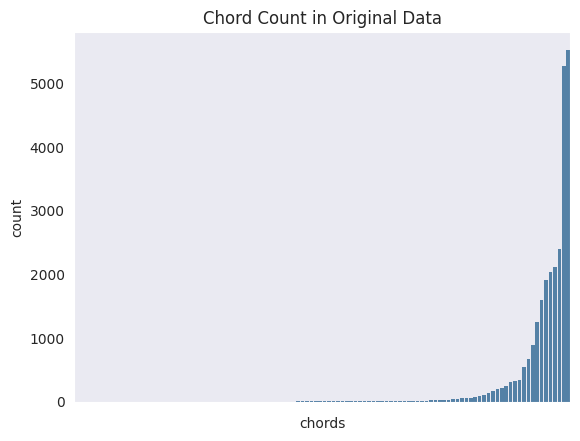

In [88]:
original_dataset_relative_path = "notebooks/data/NottinghamCleaned/nottingham_match/python/data/nottingham_jukedeck/ABC_cleaned"
songs_df, clean_songs_df,chords_occurrences = prepare_dataset_for_EDA(relative_path=original_dataset_relative_path)
ax1 =sns.barplot(data=chords_occurrences,y="count", x='chords',edgecolor='none',color="steelblue")
ax1.set(xticklabels=[])
ax1.set_title("Chord Count in Original Data")

In [14]:
chords_occurrences.value_counts()

chords   count
""       5        1
"(A7)"   2        1
"Em/d+"  1        1
"Em/d"   6        1
"Em/c+"  1        1
                 ..
"Bm/f+"  2        1
"Bm/d"   1        1
"Bm/a"   5        1
"Bm"     674      1
"Gm/d"   7        1
Length: 112, dtype: int64

In [3]:
songs_df["original_body"].str.contains("P:")

0        True
1        True
2       False
3       False
4        True
        ...  
1029    False
1030    False
1031     True
1032    False
1033    False
Name: original_body, Length: 1034, dtype: bool

Index(['chords', 'count'], dtype='object')


Text(0.5, 1.0, 'Chord Count in Clean Data')

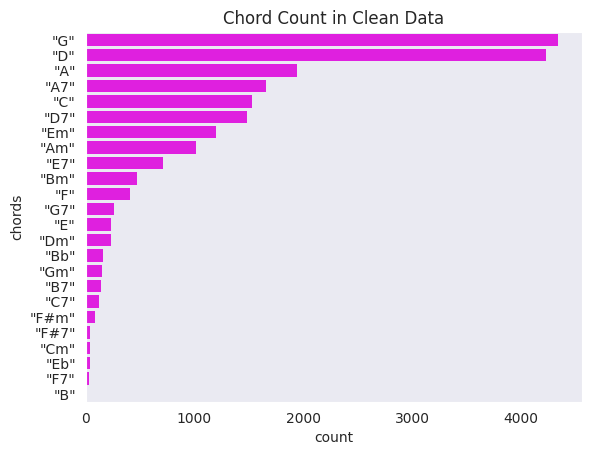

In [20]:
chords_names = clean_songs_df.columns[clean_songs_df.columns.str.contains('"[^"]*"')]

chords_occurrences_df = clean_songs_df[chords_names].sum().sort_values(ascending=False).reset_index()
chords_occurrences_df = chords_occurrences_df.rename({'index':'chords', 0:'count'},axis=1)
print(chords_occurrences_df.columns)
ax1 = sns.barplot(data=chords_occurrences_df,y="chords", x='count',edgecolor='none',color="magenta")
ax1.set_title("Chord Count in Clean Data")

Text(0.5, 1.0, 'Keys histogram in Original Dataset')

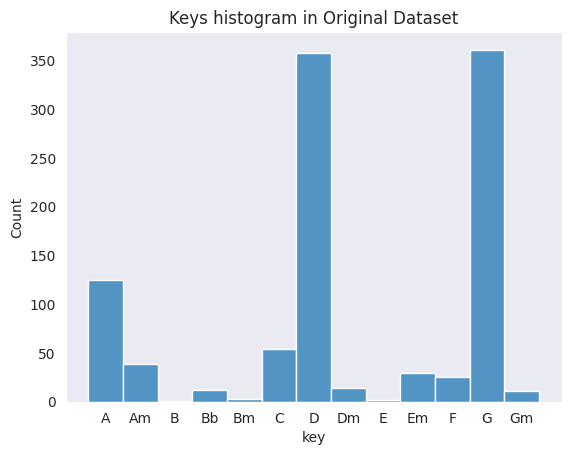

In [23]:
ax1 = sns.histplot(songs_df["key"].astype("category"))
ax1.set_title("Keys histogram in Original Dataset")

Text(0.5, 1.0, 'Key Comparison')

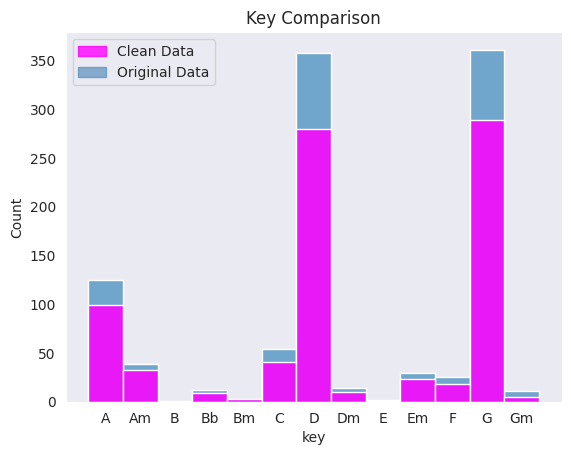

In [89]:
#fig, ax = plt.subplots()
import matplotlib.patches as mpatches
ax = sns.histplot(songs_df["key"].astype("category"),label="abc",alpha=0.6)
ax = sns.histplot(clean_songs_df["key"].astype("category"), ax=ax,label="something 2",color="magenta",alpha=0.85)
magenta_patch = mpatches.Patch(color='magenta',alpha=0.8, label='Clean Data')
blue_patch = mpatches.Patch(color='steelblue',alpha=0.6, label='Original Data')
plt.legend(handles=[magenta_patch, blue_patch])
ax.set_title("Key Comparison")

In [7]:
clean_songs_df.columns[clean_songs_df.columns.str.contains('"[\(]')]

Index([], dtype='object')

In [8]:
chord_names = clean_songs_df.columns[clean_songs_df.columns.str.contains('"')].to_list()
sum_chords = clean_songs_df[chord_names].sum().sort_values().reset_index()
chords = "|"
for chord_name,chord_count in zip(sum_chords["index"],sum_chords[0]):
    chords = chords+chord_name+'|'
    print(chord_name,chord_count)
print(chords)

"B" 17
"F7" 33
"Eb" 37
"Cm" 38
"F#7" 39
"F#m" 88
"C7" 120
"B7" 138
"Gm" 148
"Bb" 157
"Dm" 232
"E" 238
"G7" 258
"F" 407
"Bm" 473
"E7" 716
"Am" 1018
"Em" 1195
"D7" 1484
"C" 1529
"A7" 1654
"A" 1946
"D" 4232
"G" 4338
|"B"|"F7"|"Eb"|"Cm"|"F#7"|"F#m"|"C7"|"B7"|"Gm"|"Bb"|"Dm"|"E"|"G7"|"F"|"Bm"|"E7"|"Am"|"Em"|"D7"|"C"|"A7"|"A"|"D"|"G"|


In [9]:
print(clean_songs_df["chord_progression"].str.contains("segno").value_counts())

False    811
Name: chord_progression, dtype: int64


In [10]:
print(songs_df["chord_progression"].str.contains("segno").value_counts())

False    1034
Name: chord_progression, dtype: int64


In [11]:
for song,title,book in zip(clean_songs_df["clean_body"],clean_songs_df["title"],clean_songs_df["tuneBook"]):
    print(title," ", book)
    print(song)
    print("**"*10)

The Indian Queen   playford.abc
f/2g/2|"D"afdf|"A7"e2A2|"D"FAAf|"Em"e2-"A7"ef/2g/2|"D"afdf|"A7"e2A2|"D"FAAf|"D"d3|c/2d/2|"A"e/2d/2c/2B/2Ae|"F#m"fc"Bm"dB|"D"f/2g/2a"E7"b^g|"A7"a3e/2f/2|"G"g/2f/2e/2d/2"A"ca|"Em"Bg"A7"Af/2g/2|"G"ed"A7"ec|"D"d3|]
********************
Mr Beveridge's Maggot   playford.abc
"Gm"g4"D7"^f2=ef"Gm"g4|"Cm"d2cB"D7"ABc2"Gm"B2G2|"Gm"g4"F7"a2ga"Bb"b4|"Eb"f2ed"F7"cde2"Bb"d2B2|"Bb"d2f4f2f4|"F"c2e4e2e4|"Gm"B2d4d2d2cB|"Cm"ABc2"A7"B2AG"D7"^F2D2|"D7"d2a4a2a2d2|"Gm"b2a2"D7"g2^f2"Gm"g4|"Bb"def2Bcd2"F"ABc2|"Cm"B2G2"D7"G2^F2"Gm"G4|]
********************
Nancy's Fancy   playford.abc
|D|"G"GBBA/2B/2|"D7"cAAd|"G"BGGB|"Am"A/2G/2F/2E/2"D7"DD|"G"GB"Em"BA/2B/2|"Am"cA"D7"Ad|"G"BG"D7"AF|"G"G2G|g|fedc|"G"BAGB|"G"dgdB|"D"B2Ag|fedc|BABc|"G"dg"D7"fd|"G"g2g2|"Em"BBB/2A/2B|"Am"ccc/2B/2c|"Em"BBB/2A/2B|"D7"A/2G/2F/2E/2DD|"Em"BBB/2A/2B|"Am"ccc/2B/2c|"Em"BG"D7"AF|"G"G2G|]
********************
Never Love Thee More   playford.abc
"G"DEDG2A|"G"BcBA2G|"G7"dB2A2G|"C"E3-E3|"G"DEDG2A|"G"BcBA2G|"G"dB2c2d|

In [12]:
descriptive_names = {
                        'X': 'reference_number',
                        'T': 'title',
                        'S': 'source',
                        'M': 'meter',
                        'L': 'unit_note_length',
                        'R': 'rhythm',
                        'P': 'parts',
                        'K': 'key',
                        'F': 'file_name',
                        'N': 'notes'
                        }

4/4    548
6/8    359
3/4     60
2/4     41
9/8     13
2/2      7
3/2      3
6/4      2
Name: meter, dtype: int64

Sum of values: 1033

NaN values: 1


Text(0.5, 1.0, 'Meter Histogram in Original Data')

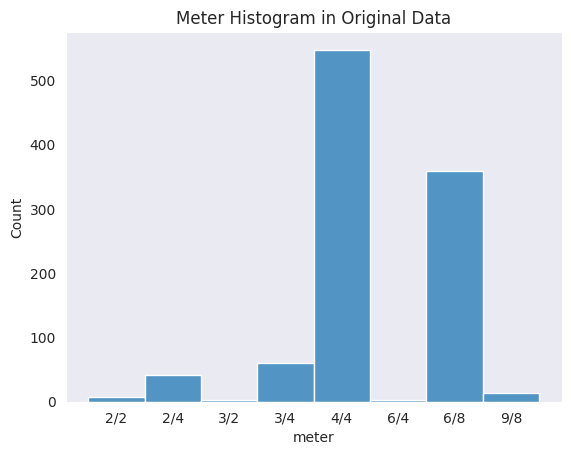

In [63]:
category_name = "meter"
category_value_counts = songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",songs_df[category_name].isna().sum())
ax1 = sns.histplot(songs_df[category_name].astype("category"))
ax1.set_title("Meter Histogram in Original Data")

4/4    440
6/8    279
3/4     38
2/4     37
9/8     10
2/2      5
3/2      1
6/4      1
Name: meter, dtype: int64

Sum of values: 811

NaN values: 0


Text(0.5, 1.0, 'Clean Data Meter Histogram')

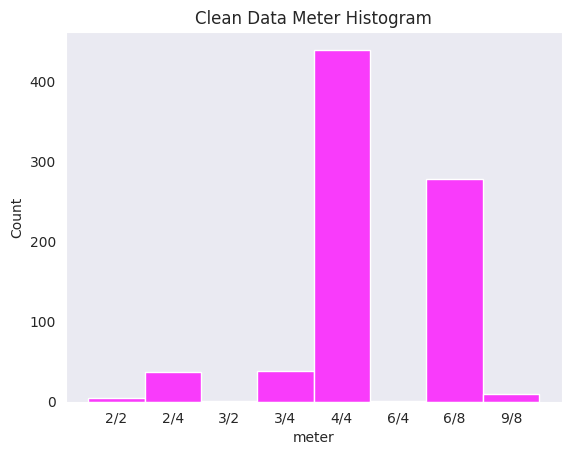

In [55]:

category_name = "meter"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
ax1 = sns.histplot(clean_songs_df[category_name].astype("category"),color="magenta")
ax1.set_title("Clean Data Meter Histogram")


Hornpipe    65
Name: rhythm, dtype: int64

Sum of values: 65

NaN values: 969


<AxesSubplot: xlabel='rhythm', ylabel='Count'>

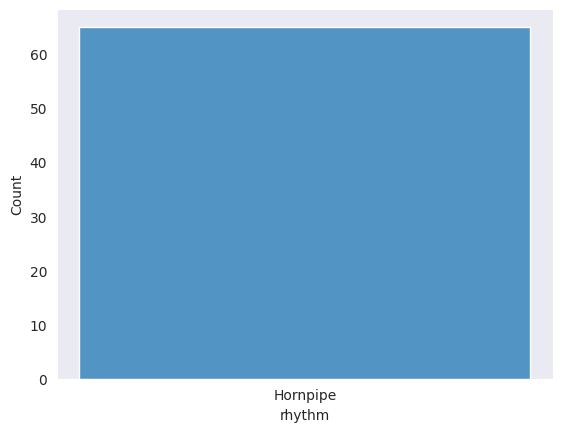

In [14]:
category_name = "rhythm"
category_value_counts = songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",songs_df[category_name].isna().sum())
sns.histplot(songs_df[category_name].astype("category"))

1/4    569
1/8     75
Name: unit_note_length, dtype: int64

Sum of values: 644

NaN values: 390


Text(0.5, 1.0, 'Unit Note Length Count in Original Data')

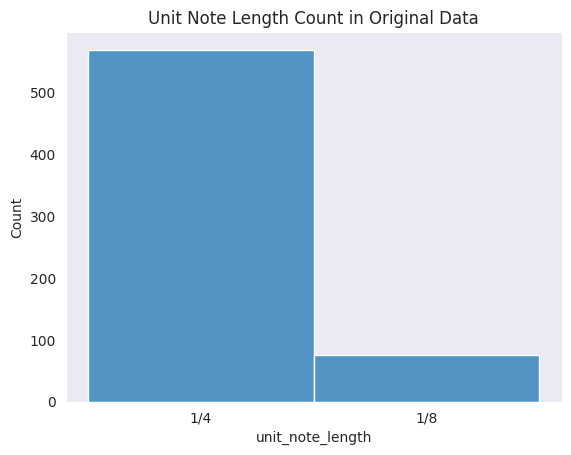

In [64]:
category_name = "unit_note_length"
category_value_counts = songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",songs_df[category_name].isna().sum())
ax1 = sns.histplot(songs_df[category_name].astype("category"))
ax1.set_title("Unit Note Length Count in Original Data")

G     289
D     280
A      99
C      41
Am     33
Em     23
F      18
Dm     10
Bb      9
Gm      5
Bm      3
E       1
Name: key, dtype: int64

Sum of values: 811

NaN values: 0


<AxesSubplot: xlabel='key', ylabel='Count'>

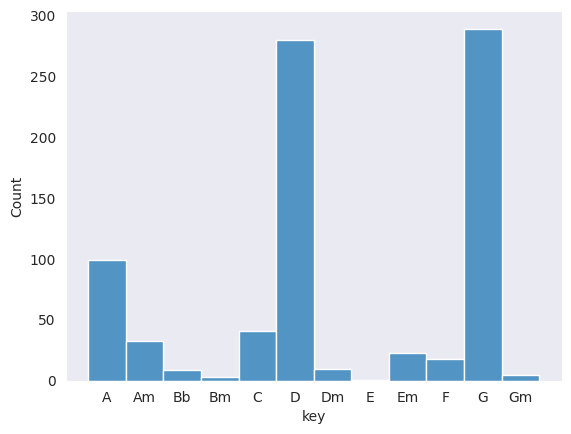

In [78]:
category_name = "key"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
sns.histplot(clean_songs_df[category_name].astype("category"))

Text(0.5, 1.0, 'Number of Songs per TuneBook')

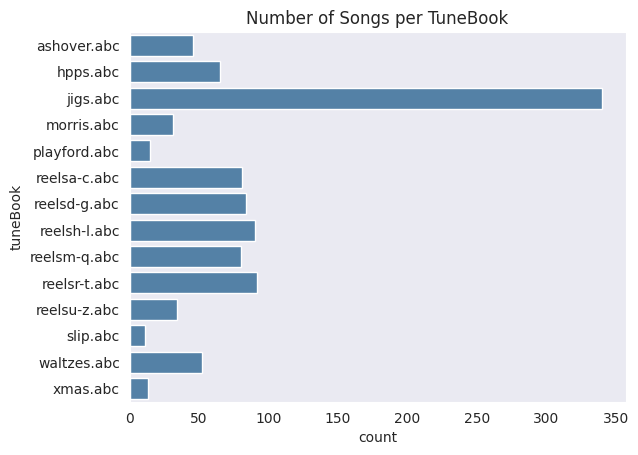

In [81]:
category_name = "tuneBook"
rename_dict = {category_name:'count','index':"tuneBook"}
aux_df_2 = songs_df[category_name].astype("category").value_counts().reset_index().rename(rename_dict,axis=1)
ax = sns.barplot(data=aux_df_2, y='tuneBook', x='count',label="Original Dataset", color='steelblue')
ax.set_title("Number of Songs per TuneBook")

jigs.abc        260
reelsr-t.abc     75
reelsh-l.abc     71
reelsd-g.abc     70
reelsm-q.abc     68
reelsa-c.abc     62
hpps.abc         57
ashover.abc      43
waltzes.abc      31
reelsu-z.abc     26
morris.abc       18
slip.abc         11
playford.abc     10
xmas.abc          9
Name: tuneBook, dtype: int64

Sum of values: 811

NaN values: 0


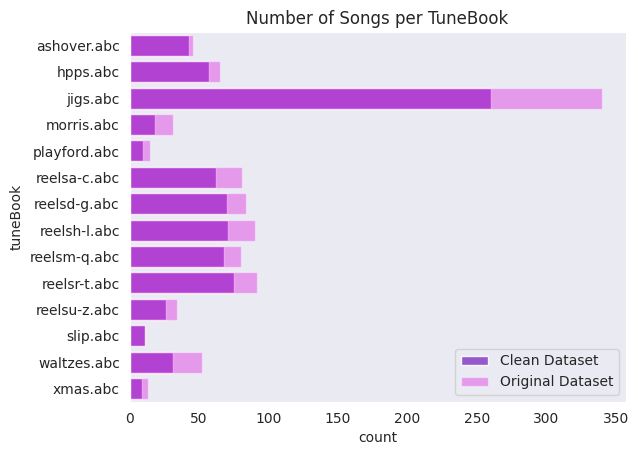

In [91]:
category_name = "tuneBook"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
rename_dict = {category_name:'count','index':"tuneBook"}
aux_df_1 = clean_songs_df[category_name].astype("category").value_counts().reset_index().rename(rename_dict,axis=1)
aux_df_2 = songs_df[category_name].astype("category").value_counts().reset_index().rename(rename_dict,axis=1)
ax1= sns.barplot(data=aux_df_1, y='tuneBook', x='count',label="Clean Dataset", color='#8D34DC',alpha=0.9)
sns.barplot(ax=ax1,data=aux_df_2, y='tuneBook', x='count',label="Original Dataset", color='magenta',alpha=0.4)
plt.title("Number of Songs per TuneBook")
plt.legend(loc='lower right')
plt.show()

1/4    448
1/8    363
Name: unit_note_length, dtype: int64

Sum of values: 811

NaN values: 0


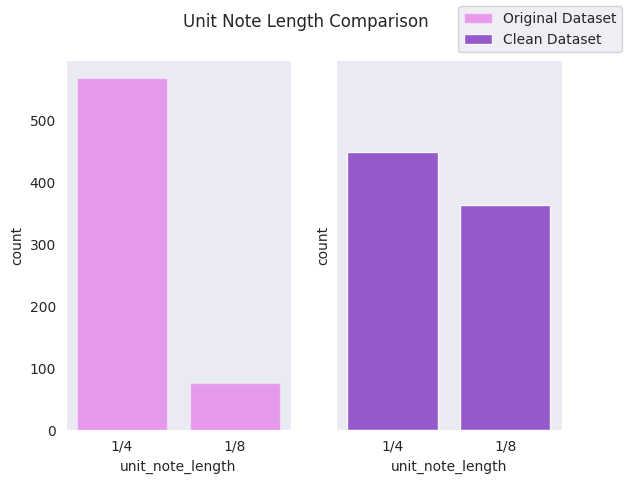

In [92]:
category_name = "unit_note_length"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
rename_dict = {category_name:'count','index':"unit_note_length"}
aux_df_1 = clean_songs_df[category_name].astype("category").value_counts().reset_index().rename(rename_dict,axis=1)
aux_df_2 = songs_df[category_name].astype("category").value_counts().reset_index().rename(rename_dict,axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2 ,sharey=True)
sns.barplot(ax=ax2,data=aux_df_1, x='unit_note_length', y='count',label="Clean Dataset", color='#8D34DC',alpha=0.9)
sns.barplot(ax=ax1,data=aux_df_2, x='unit_note_length', y='count',label="Original Dataset", color='magenta',alpha=0.4)
fig.suptitle('Unit Note Length Comparison')
fig.legend()
plt.show()

4/4    440
6/8    279
3/4     38
2/4     37
9/8     10
2/2      5
3/2      1
6/4      1
Name: meter, dtype: int64

Sum of values: 811

NaN values: 0


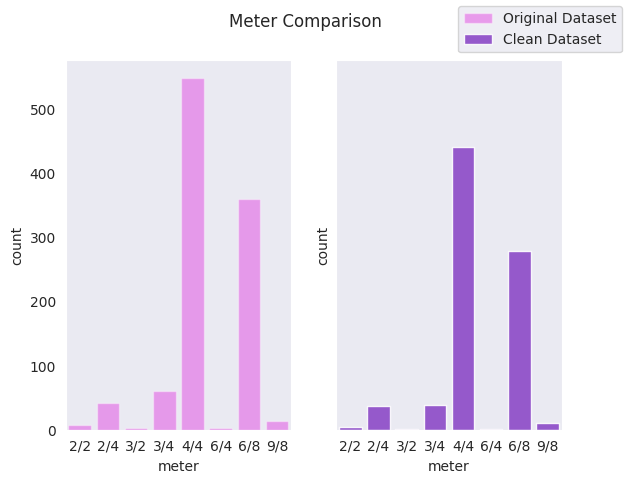

In [93]:
category_name = "meter"
category_value_counts = clean_songs_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_df[category_name].isna().sum())
rename_dict = {category_name:'count','index':"meter"}
aux_df_1 = clean_songs_df[category_name].astype("category").value_counts().reset_index().rename(rename_dict,axis=1)
aux_df_2 = songs_df[category_name].astype("category").value_counts().reset_index().rename(rename_dict,axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2 ,sharey=True)
sns.barplot(ax=ax2,data=aux_df_1, x='meter', y='count',label="Clean Dataset", color='#8D34DC',alpha=0.9)
sns.barplot(ax=ax1,data=aux_df_2, x='meter', y='count',label="Original Dataset", color='magenta',alpha=0.4)
fig.suptitle('Meter Comparison')
fig.legend()
plt.show()

Text(0.5, 1.0, 'Datasets Values')

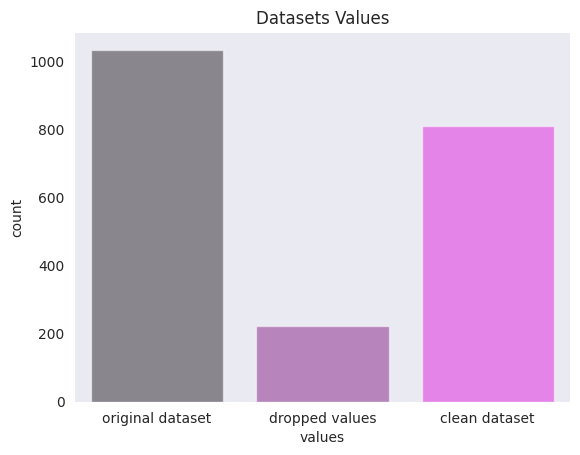

In [94]:
df_aux = pd.DataFrame({
        "clean dataset":[clean_songs_df.shape[0]],
        "original dataset":[songs_df.shape[0]]
        })
df_aux["dropped values"] = df_aux["original dataset"]-df_aux["clean dataset"]
ordered_list_values = ["dropped values","original dataset","clean dataset"]
magenta_palette = sns.dark_palette('magenta', n_colors=len(ordered_list_values))
reversed_magenta_palette = list(reversed(magenta_palette))
color_dict  = dict(zip(ordered_list_values, reversed_magenta_palette))
ordered_list_values = ["original dataset","dropped values","clean dataset"]
df_aux = df_aux[ordered_list_values]
df_aux = df_aux.T.reset_index().rename({"index":"values",0:"count"},axis=1)
ax = sns.barplot(data=df_aux,x="values",y="count",palette=magenta_palette,alpha=0.5)
plt.title("Datasets Values")


In [21]:
clean_songs_df["meter"].value_counts()

4/4    440
6/8    279
3/4     38
2/4     37
9/8     10
2/2      5
3/2      1
6/4      1
Name: meter, dtype: int64

In [22]:
clean_songs_df["meter"].isna().sum()

0

In [23]:
print(clean_songs_df["unit_note_length"].value_counts())
print(clean_songs_df["unit_note_length"].isna().sum())

1/4    448
1/8    363
Name: unit_note_length, dtype: int64
0


In [24]:
clean_songs_df.columns.sort_values()

Index(['"A"', '"A7"', '"Am"', '"B"', '"B7"', '"Bb"', '"Bm"', '"C"', '"C7"',
       '"Cm"', '"D"', '"D7"', '"Dm"', '"E"', '"E7"', '"Eb"', '"Em"', '"F"',
       '"F#7"', '"F#m"', '"F7"', '"G"', '"G7"', '"Gm"', 'chord_progression',
       'clean_body', 'key', 'meter', 'original_body', 'original_header',
       'reference_number', 'title', 'tuneBook', 'unit_note_length'],
      dtype='object')

In [25]:
print("Number of NaN in the entire dataset:",clean_songs_df.isna().sum().sum())

Number of NaN in the entire dataset: 0


## Save Intermediate datasets

In [95]:
relative_path ="notebooks/data/original_dataset"
clean_dataset_for_augmentation_df = generate_clean_songs(clean_songs_df,for_training=False)


filename_name = 'clean_original_data'
save_dataframe(clean_dataset_for_augmentation_df,relative_path,filename_name)
write_tuneBook_file(clean_dataset_for_augmentation_df,relative_path,filename_name)

clean_dataset_for_training_df = generate_clean_songs(clean_songs_df,for_training=True)
filename_name = 'clean_original_training_data'
save_dataframe(clean_dataset_for_training_df,relative_path,filename_name)
write_tuneBook_file(clean_dataset_for_training_df,relative_path,filename_name)


clean_original_data  dataset shape (811, 36)
Index(['unit_note_length', 'tuneBook', 'title', 'reference_number',
       'original_header', 'original_body', 'meter', 'key', 'clean_song',
       'clean_header', 'clean_body', 'chord_progression', '"Gm"', '"G7"',
       '"G"', '"F7"', '"F#m"', '"F#7"', '"F"', '"Em"', '"Eb"', '"E7"', '"E"',
       '"Dm"', '"D7"', '"D"', '"Cm"', '"C7"', '"C"', '"Bm"', '"Bb"', '"B7"',
       '"B"', '"Am"', '"A7"', '"A"'],
      dtype='object')
----------
clean_original_training_data  dataset shape (811, 36)
Index(['unit_note_length', 'tuneBook', 'title', 'reference_number',
       'original_header', 'original_body', 'meter', 'key', 'clean_song',
       'clean_header', 'clean_body', 'chord_progression', '"Gm"', '"G7"',
       '"G"', '"F7"', '"F#m"', '"F#7"', '"F"', '"Em"', '"Eb"', '"E7"', '"E"',
       '"Dm"', '"D7"', '"D"', '"Cm"', '"C7"', '"C"', '"Bm"', '"Bb"', '"B7"',
       '"B"', '"Am"', '"A7"', '"A"'],
      dtype='object')
----------


In [96]:
relative_path ="notebooks/data/original_dataset"
filename_name = 'clean_original_data'
clean_dataset_for_augmentation_df = load_dataframe(relative_path,filename_name)
filename_name = 'clean_original_training_data'
clean_dataset_for_training_df = load_dataframe(relative_path,filename_name)

In [97]:
print("augmentation dataset shape",clean_dataset_for_augmentation_df.shape)
print(clean_dataset_for_augmentation_df.columns)
print("training dataset shape",clean_dataset_for_training_df.shape)
print(clean_dataset_for_training_df.columns)

augmentation dataset shape (811, 36)
Index(['unit_note_length', 'tuneBook', 'title', 'reference_number',
       'original_header', 'original_body', 'meter', 'key', 'clean_song',
       'clean_header', 'clean_body', 'chord_progression', '"Gm"', '"G7"',
       '"G"', '"F7"', '"F#m"', '"F#7"', '"F"', '"Em"', '"Eb"', '"E7"', '"E"',
       '"Dm"', '"D7"', '"D"', '"Cm"', '"C7"', '"C"', '"Bm"', '"Bb"', '"B7"',
       '"B"', '"Am"', '"A7"', '"A"'],
      dtype='object')
training dataset shape (811, 36)
Index(['unit_note_length', 'tuneBook', 'title', 'reference_number',
       'original_header', 'original_body', 'meter', 'key', 'clean_song',
       'clean_header', 'clean_body', 'chord_progression', '"Gm"', '"G7"',
       '"G"', '"F7"', '"F#m"', '"F#7"', '"F"', '"Em"', '"Eb"', '"E7"', '"E"',
       '"Dm"', '"D7"', '"D"', '"Cm"', '"C7"', '"C"', '"Bm"', '"Bb"', '"B7"',
       '"B"', '"Am"', '"A7"', '"A"'],
      dtype='object')


In [29]:
for song in clean_dataset_for_augmentation_df.tail()["clean_song"]:
    print(song)

X:78
T:Grandpa's
M:4/4
L:1/4
K:D
A/2G/2|"D"FA"A7"Bc|"D"d/2c/2d/2e/2fa|"Em"gf"E7"ed|"A7"cBAG|"D"FA"A7"Bc|"D"d/2c/2d/2e/2fa|"Em"gf"A7"eB/2c/2|"D"d3|"D"d4|"A"e/2c/2Ae/2c/2A|"G"gf"A"e/2c/2A|"G"gf"E7"ed|"A7"cBAG|"D"FA"A7"Bc|"D"d/2c/2d/2e/2fa|"Em"gf"A7"eB/2c/2|"D"d3z|]

X:79
T:The Girl With The Green Hat On
M:4/4
L:1/4
K:D
(3A/2B/2c/2|"D"dA"A7"A/2B/2A/2G/2|"D"F/2G/2A/2B/2"A7"AA/2G/2|"D"F/2A/2d/2e/2fd|"A7"eAA(3A/2B/2c/2|"D"dA"A7"A/2B/2A/2G/2|"D"F/2G/2A/2B/2A/2B/2c/2d/2|"E7"e/2f/2e/2d/2"A7"c/2A/2B/2c/2|"D"dDDc/2d/2|"A"eAe/2c/2d/2e/2|"D"fdfe/2f/2|"Em"gfed|"A"cBAc/2d/2|eAe/2c/2d/2e/2|"D"fdfe/2f/2|"Em"gf"A7"ec|"D"edd|]

X:80
T:Green Meadow
M:4/4
L:1/4
K:G
(3D/2E/2F/2|"G"GG/2A/2B/2G/2B/2d/2|"C"e/2f/2g/2e/2"G"d/2B/2A/2G/2|"Am"E/2A/2A/2G/2A/2B/2A/2G/2|"Am"E/2A/2A/2G/2"D7"A/2c/2B/2A/2|"G"G/2F/2G/2A/2B/2G/2B/2d/2|"C"e/2f/2g/2e/2"G"d/2B/2A/2G/2|"C"E/2G/2G/2F/2G/2A/2G/2E/2|"D7"D/2G/2G/2F/2"G"Gg/2a/2|"G"bb/2g/2"D7"a/2b/2a/2f/2|"C"g/2a/2g/2e/2"G"dB/2d/2|"Am"e/2a/2a/2g/2a/2b/2a/2g/2|"Am"e/2a/2a/2g/2"D7"ag/

In [30]:
for song in clean_dataset_for_training_df.tail()["clean_song"]:
    print(song)

M:4/4
L:1/4
K:D
|"D""A7"|"D"|"Em""E7"|"A7"|"D""A7"|"D"|"Em""A7"|"D"|"D"|"A"|"G""A"|"G""E7"|"A7"|"D""A7"|"D"|"Em""A7"|"D"|]
A/2G/2|"D"FA"A7"Bc|"D"d/2c/2d/2e/2fa|"Em"gf"E7"ed|"A7"cBAG|"D"FA"A7"Bc|"D"d/2c/2d/2e/2fa|"Em"gf"A7"eB/2c/2|"D"d3|"D"d4|"A"e/2c/2Ae/2c/2A|"G"gf"A"e/2c/2A|"G"gf"E7"ed|"A7"cBAG|"D"FA"A7"Bc|"D"d/2c/2d/2e/2fa|"Em"gf"A7"eB/2c/2|"D"d3z|]

M:4/4
L:1/4
K:D
|"D""A7"|"D""A7"|"D"|"A7"|"D""A7"|"D"|"E7""A7"|"D"|"A"|"D"|"Em"|"A"|"D"|"Em""A7"|"D"|]
(3A/2B/2c/2|"D"dA"A7"A/2B/2A/2G/2|"D"F/2G/2A/2B/2"A7"AA/2G/2|"D"F/2A/2d/2e/2fd|"A7"eAA(3A/2B/2c/2|"D"dA"A7"A/2B/2A/2G/2|"D"F/2G/2A/2B/2A/2B/2c/2d/2|"E7"e/2f/2e/2d/2"A7"c/2A/2B/2c/2|"D"dDDc/2d/2|"A"eAe/2c/2d/2e/2|"D"fdfe/2f/2|"Em"gfed|"A"cBAc/2d/2|eAe/2c/2d/2e/2|"D"fdfe/2f/2|"Em"gf"A7"ec|"D"edd|]

M:4/4
L:1/4
K:G
|"G"|"C""G"|"Am"|"Am""D7"|"G"|"C""G"|"C"|"D7""G"|"G""D7"|"C""G"|"Am"|"Am""D7"|"G""D7"|"C""G"|"C"|"D7""G"|"D7"|]
(3D/2E/2F/2|"G"GG/2A/2B/2G/2B/2d/2|"C"e/2f/2g/2e/2"G"d/2B/2A/2G/2|"Am"E/2A/2A/2G/2A/2B/2A/2G/2|"Am"E/2A/2A/2G/2"D7"A

## Load Augmented Datasets

In [98]:

augmented_dataset_relative_path = "notebooks/data/augmented_dataset"
songs_df_augmented, clean_songs_augmented_df ,chords_occurrences_aug= prepare_dataset_for_EDA(relative_path=augmented_dataset_relative_path,drop_by_occurrences=True,drop_occur_threshold=20, drop_by_extended_chord=True, drop_more_than_one_voice=True)
clean_songs_augmented_df


number of values to be dropped:
 False    9732
dtype: int64
number chords least occurrences:  2
chords least occurrences ['"f"', '"Bf\'"']
number of values to be dropped:
 False    9724
True        8
dtype: int64
Number of dropped songs with more than one voice: 228
******************************


,reference_number,title,meter,unit_note_length,key,tuneBook,original_header,original_body,"""A""","""e7""",...,"""A#m""","""dd'""","""Gd'""","""A#7""","""F#m""","""F#7""","""C#m""","""Ff""","""Bf""","""C#7"""
0,6,The Indian Queen,4/4,1/4,Ab,dataset_6.abc,X:6\nT:The Indian Queen\nM:4/4\nL:1/4\nK:Abmajor,"c'/2d'/2|""A""e'c'ac'|""e7""b2e2|""A""ceec'|""Bm""b2-""...",7,6,...,0,0,0,0,0,0,0,0,0,0
1,7,Mr Beveridge's Maggot,3/2,1/8,C#m,dataset_6.abc,X:7\nT:Mr Beveridge's Maggot\nM:3/2\nL:1/8\nK:...,"""cm""c'4""G7""^b2^ab""cm""c'4|""Fm""g2fe""G7""def2""cm""e...",0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,Nancy's Fancy,4/4,1/4,Db,dataset_6.abc,X:8\nT:Nancy's Fancy\nM:4/4\nL:1/4\nK:Dbmajor,"|A|""d""dffe/2f/2|""A7""geea|""d""fddf|""em""e/2d/2c/2...",1,0,...,0,0,0,0,0,0,0,0,0,0
3,9,Never Love Thee More,6/8,1/8,Db,dataset_6.abc,X:9\nT:Never Love Thee More\nM:6/8\nL:1/8\nK:D...,"""d""ABAd2e|""d""fgfe2d|""d7""af2e2d|""G""B3-B3|""d""ABA...",0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,Nonesuch,4/4,1/4,G#m,dataset_6.abc,X:10\nT:Nonesuch\nM:4/4\nL:1/4\nK:G#minor,"d'|""Gm""d'bc'd'|""Gm""ba/2b/2gd'|""Gm""d'bc'd'|""Gm""...",0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9491,78,Grandpa's,4/4,1/4,A,dataset_min5.abc,X:78\nT:Grandpa's\nM:4/4\nL:1/4\nK:Amajor,"E/2D/2|""A,""CE""E7""FG|""A,""A/2G/2A/2B/2ce|""B,m""dc...",9,0,...,0,0,0,0,0,0,0,0,0,0
9492,79,The Girl With The Green Hat On,4/4,1/4,A,dataset_min5.abc,X:79\nT:The Girl With The Green Hat On\nM:4/4\...,"(3E/2F/2G/2|""A,""AE""E7""E/2F/2E/2D/2|""A,""C/2D/2E...",9,0,...,0,0,0,0,0,0,0,0,0,0
9493,80,Green Meadow,4/4,1/4,D,dataset_min5.abc,X:80\nT:Green Meadow\nM:4/4\nL:1/4\nK:Dmajor,"(3A,/2B,/2C/2|""D""DD/2E/2F/2D/2F/2A/2|""G,""B/2c/...",0,0,...,0,0,0,0,0,0,0,0,0,0
9494,82,The Old Grey Cat,4/4,1/4,Bm,dataset_min5.abc,X:82\nT:The Old Grey Cat\nM:4/4\nL:1/4\nK:Bminor,"F|""B,m""BBB,B,/2C/2|""B,m""D/2C/2D/2E/2F/2E/2F/2^...",5,0,...,0,0,0,0,0,0,0,0,0,0


## EDA Augmented dataset

Index(['key', 'count', 'mode'], dtype='object')
Index(['key', 'count', 'mode'], dtype='object')
key               object
count              int64
mode              object
dataset_type    category
dtype: object
key             category
count              int64
mode            category
dataset_type    category
dtype: object


Text(0.5, 1.05, 'Key Count Comparison')

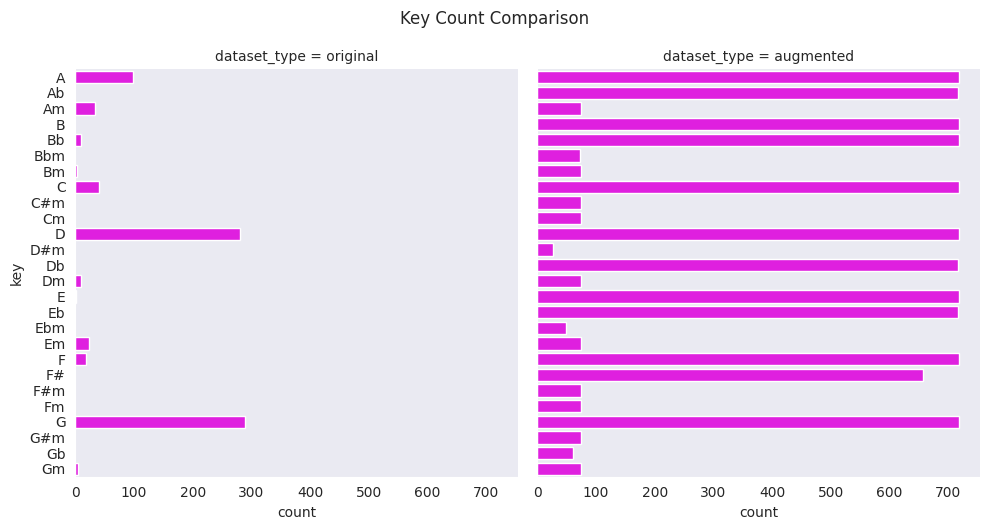

In [121]:
 def get_df_with_key_count(df,col_name="key"):
    category_name = col_name
    key_categories = df[category_name].astype("category").value_counts()
    key_categories = key_categories.reset_index().sort_values(by=[category_name,"index"],ascending=[False, True])
    #key_categories["tuneBook"] = clean_songs_augmented_df["tuneBook"]
    key_categories = key_categories.rename(columns={'index': category_name, category_name: 'count'})

    major_or_minor = lambda row: "Minor" if 'm' in row[category_name] else "Major"
    key_categories["mode"] = key_categories.apply(major_or_minor,axis=1)
    print(key_categories.columns)
    return key_categories

key_categories_1 = get_df_with_key_count(clean_songs_augmented_df)
key_categories_1["dataset_type"] = "augmented"
#sns.catplot(data=key_categories_1,y="key",x="count",order=key_categories_1['key'],kind='bar')
key_categories_2 = get_df_with_key_count(clean_songs_df)
key_categories_2["dataset_type"] = "original"
#sns.catplot(data=key_categories_2,y="key",x="count",order=key_categories_2['key'],kind='bar')

key_categories = pd.concat([key_categories_1,key_categories_2],axis=0)
key_categories['dataset_type'] = pd.Categorical(key_categories['dataset_type'], categories=['original', 'augmented'], ordered=True)
key_categories['count'] = pd.to_numeric(key_categories['count'])
print(key_categories.dtypes)
key_categories['key'] = key_categories['key'].astype('category')
key_categories['mode'] = key_categories['mode'].astype('category')
print(key_categories.dtypes)
magenta_palette = sns.light_palette('magenta', n_colors=len(key_categories['count'].unique()))
color_dict  = dict(zip(key_categories['count'].sort_values(ascending=True).unique(), magenta_palette))
ax = sns.catplot(data=key_categories,y="key",x="count",kind='bar',col='dataset_type',palette=['magenta'])
ax.fig.suptitle('Key Count Comparison',y=1.05)

In [58]:
for chord in chords_occurrences_aug.sort_values(by="count",ascending=False)["chords"]:
    print(chord)
chords_occurrences_aug.sort_values(by="count",ascending=False).iloc[-40:]

"A"
"B"
"E"
"F"
"D"
"G"
"B7"
"F7"
"A7"
"C"
"d"
"c"
"E7"
"Bm"
"Gm"
"Fm"
"G7"
"C7"
"c7"
"Em"
"Am"
"cm"
"D7"
"Cm"
"Dm"
"d7"
"e"
"dm"
"e7"
"em"
"fm"
"Gg"
"dd'"
"Aa"
"ee'"
"Bb"
"cc'"
"G#m"
"D#m"
"F#m"
"Ff"
"f7"
"B#m"
"A#m"
"E#m"
"c#m"
"C#m"
"D#7"
"G#7"
"A#7"
"Gd'"
"F#7"
"Da"
"Cg"
"Ae'"
"Eb"
"E#7"
"B#7"
"C#7"
"c#7"
"Fc'"
"Bf"
"ff'"
"f"
"Bf'"


,chords,count
39,"""d7""",2204
38,"""e""",1961
37,"""dm""",1855
36,"""e7""",1783
35,"""em""",1623
34,"""fm""",473
33,"""Gg""",314
32,"""dd'""",314
31,"""Aa""",303
30,"""ee'""",285


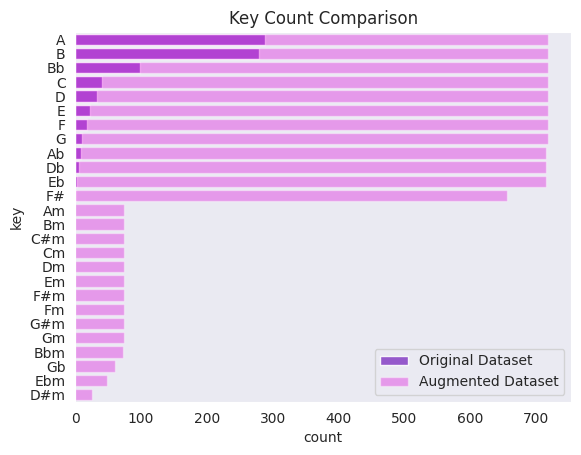

In [136]:
sns.barplot(label="Original Dataset",data=key_categories_2,y="key",x="count",order=key_categories_2['key'], color='#8D34DC',alpha=0.9)
ax1 = sns.barplot(label="Augmented Dataset",data=key_categories_1,y="key",x="count",order=key_categories_1['key'], color='magenta',alpha=0.4)
ax1.set_title("Key Count Comparison")
ax1.legend()
plt.show()

Index(['index', 0], dtype='object')


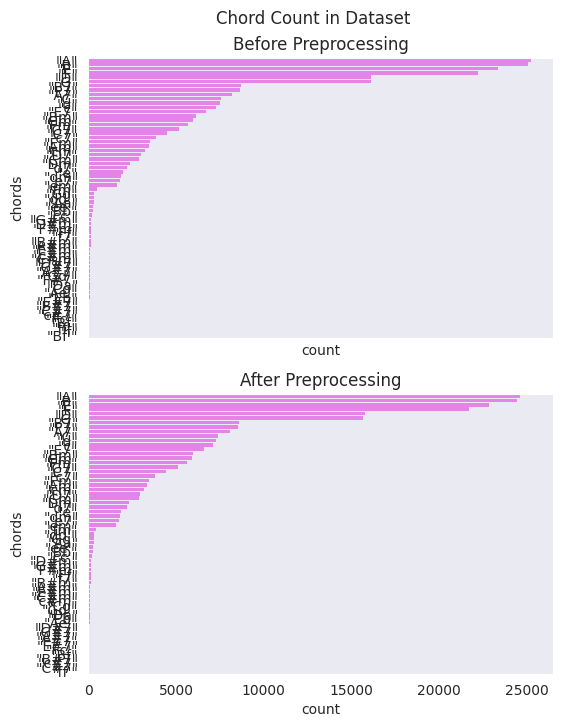

In [36]:
def get_key_bar_plots(old_df, new_df):
    chords_occurrences_aug = old_df
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8),sharex=True)
    sns.barplot(ax=ax1,data=chords_occurrences_aug.sort_values(by="count",ascending=False),x="count", y='chords',edgecolor='none',color="magenta",alpha=0.5)
    ax1.set_title('Before Preprocessing')

    clean_songs_augmented_df= new_df
    chords_names_aug = clean_songs_augmented_df.columns[clean_songs_augmented_df.columns.str.contains('"[^"]*"')]

    chords_aug_occurrences_df = clean_songs_augmented_df[chords_names_aug].sum().sort_values(ascending=False).reset_index()
    print(chords_aug_occurrences_df.columns)
    column_names = {
        'index': 'chords',
        0:'count'
        }
    chords_aug_occurrences_df = chords_aug_occurrences_df.rename(columns=column_names)
    sns.barplot(ax=ax2,data=chords_aug_occurrences_df,y="chords", x="count",edgecolor='none',color="magenta",alpha=0.5)
    ax2.set_title('After Preprocessing')

    fig.suptitle('Chord Count in Dataset', y=0.94)

get_key_bar_plots(chords_occurrences_aug,clean_songs_augmented_df)  

4/4    5123
6/8    3320
2/4     430
3/4     419
9/8     120
2/2      60
3/2      12
6/4      12
Name: meter, dtype: int64

Sum of values: 9496

NaN values: 0


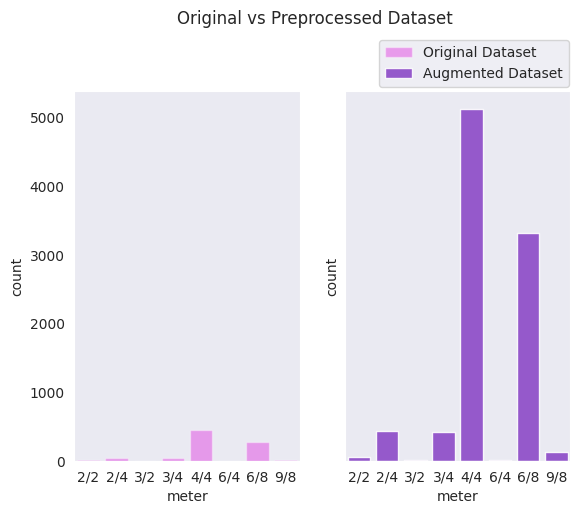

In [37]:
category_name = "meter"
category_value_counts = clean_songs_augmented_df[category_name].astype("category").value_counts()
print(category_value_counts)
print("\nSum of values:",category_value_counts.sum())
print("\nNaN values:",clean_songs_augmented_df[category_name].isna().sum())
rename_dict = {category_name:'count','index':"meter"}
aux_df_1 = clean_songs_augmented_df[category_name].astype("category").value_counts().reset_index().rename(rename_dict,axis=1)
aux_df_2 = clean_songs_df[category_name].astype("category").value_counts().reset_index().rename(rename_dict,axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2 ,sharey=True)
sns.barplot(ax=ax2,data=aux_df_1, x='meter', y='count',label="Augmented Dataset", color='#8D34DC',alpha=0.9)
sns.barplot(ax=ax1,data=aux_df_2, x='meter', y='count',label="Original Dataset", color='magenta',alpha=0.4)
fig.suptitle('Original vs Preprocessed Dataset', x=0.5, y=1.05)
fig.legend(bbox_to_anchor=(0.59, 1), loc='upper left')
plt.show()

## Save Augmented Dataset

In [38]:
#clean_dataset_for_augmentation_df = generate_clean_songs(clean_songs_augmented_df,for_training=False)
print("dataset shape",clean_songs_augmented_df.shape)
print("dataset\n",clean_songs_augmented_df.columns.sort_values(ascending=False))

clean_augmented_dataset_for_training_df = generate_clean_songs(clean_songs_augmented_df,for_training=True)

count_s = 0
print(clean_augmented_dataset_for_training_df.columns)
for song,book in zip(clean_augmented_dataset_for_training_df["clean_song"],clean_augmented_dataset_for_training_df["tuneBook"]):
    pattern = re.compile(r'\|\]')
    matches = pattern.findall(song)
    count = len(matches)
    if(count>2):
        count_s += 1
        #print(book)
        #print("Before generating songs!!!!!!!!!!!!!!!!!!!!!!")
        #print(song)
        #raise Exception
print("invalid body songs",count_s)

relative_path ="notebooks/data/final_dataset"
filename_name = 'clean_augmented_data'
save_dataframe(df=clean_augmented_dataset_for_training_df,file_name=filename_name,relative_path=relative_path)
write_tuneBook_file(clean_augmented_dataset_for_training_df,relative_path,filename_name)

dataset shape (9496, 73)
dataset
 Index(['unit_note_length', 'tuneBook', 'title', 'reference_number',
       'original_header', 'original_body', 'meter', 'key', 'clean_body',
       'chord_progression', '"fm"', '"ff'"', '"f7"', '"em"', '"ee'"', '"e7"',
       '"e"', '"dm"', '"dd'"', '"d7"', '"d"', '"cm"', '"cc'"', '"c7"', '"c#m"',
       '"c#7"', '"c"', '"Gm"', '"Gg"', '"Gd'"', '"G7"', '"G#m"', '"G#7"',
       '"G"', '"Fm"', '"Ff"', '"Fc'"', '"F7"', '"F#m"', '"F#7"', '"F"', '"Em"',
       '"Eb"', '"E7"', '"E#m"', '"E#7"', '"E"', '"Dm"', '"Da"', '"D7"',
       '"D#m"', '"D#7"', '"D"', '"Cm"', '"Cg"', '"C7"', '"C#m"', '"C#7"',
       '"C"', '"Bm"', '"Bf"', '"Bb"', '"B7"', '"B#m"', '"B#7"', '"B"', '"Am"',
       '"Ae'"', '"Aa"', '"A7"', '"A#m"', '"A#7"', '"A"'],
      dtype='object')
Index(['reference_number', 'title', 'meter', 'unit_note_length', 'key',
       'tuneBook', 'original_header', 'original_body', '"A"', '"e7"', '"Bm"',
       '"e"', '"c#m"', '"fm"', '"B7"', '"d"', 'clean_body'

In [39]:
relative_path ="notebooks/data/final_dataset"
filename_name = 'clean_augmented_data'
clean_augmented_dataset_for_training_df = pd.read_pickle(f'{relative_path}/{filename_name}.pkl')
clean_augmented_dataset_for_training_df.columns

Index(['unit_note_length', 'tuneBook', 'title', 'reference_number',
       'original_header', 'original_body', 'meter', 'key', 'clean_song',
       'clean_header', 'clean_body', 'chord_progression', '"fm"', '"ff'"',
       '"f7"', '"em"', '"ee'"', '"e7"', '"e"', '"dm"', '"dd'"', '"d7"', '"d"',
       '"cm"', '"cc'"', '"c7"', '"c#m"', '"c#7"', '"c"', '"Gm"', '"Gg"',
       '"Gd'"', '"G7"', '"G#m"', '"G#7"', '"G"', '"Fm"', '"Ff"', '"Fc'"',
       '"F7"', '"F#m"', '"F#7"', '"F"', '"Em"', '"Eb"', '"E7"', '"E#m"',
       '"E#7"', '"E"', '"Dm"', '"Da"', '"D7"', '"D#m"', '"D#7"', '"D"', '"Cm"',
       '"Cg"', '"C7"', '"C#m"', '"C#7"', '"C"', '"Bm"', '"Bf"', '"Bb"', '"B7"',
       '"B#m"', '"B#7"', '"B"', '"Am"', '"Ae'"', '"Aa"', '"A7"', '"A#m"',
       '"A#7"', '"A"'],
      dtype='object')

In [40]:
print("Final dataframe dimensions:",clean_augmented_dataset_for_training_df.shape)
clean_augmented_dataset_for_training_df.head()

Final dataframe dimensions: (9496, 75)


,unit_note_length,tuneBook,title,reference_number,original_header,original_body,meter,key,clean_song,clean_header,...,"""B#m""","""B#7""","""B""","""Am""","""Ae'""","""Aa""","""A7""","""A#m""","""A#7""","""A"""
0,1/4,dataset_6.abc,The Indian Queen,6,X:6\nT:The Indian Queen\nM:4/4\nL:1/4\nK:Abmajor,"c'/2d'/2|""A""e'c'ac'|""e7""b2e2|""A""ceec'|""Bm""b2-""...",4/4,Ab,"M:4/4\nL:1/4\nK:Ab\n|""A""|""e7""|""A""|""Bm""""e7""|""A""...","M:4/4\nL:1/4\nK:Ab\n|""A""|""e7""|""A""|""Bm""""e7""|""A""...",...,0,0,0,0,0,0,0,0,0,7
1,1/8,dataset_6.abc,Mr Beveridge's Maggot,7,X:7\nT:Mr Beveridge's Maggot\nM:3/2\nL:1/8\nK:...,"""cm""c'4""G7""^b2^ab""cm""c'4|""Fm""g2fe""G7""def2""cm""e...",3/2,C#m,"M:3/2\nL:1/8\nK:C#m\n|""cm""""G7""""cm""|""Fm""""G7""""cm...","M:3/2\nL:1/8\nK:C#m\n|""cm""""G7""""cm""|""Fm""""G7""""cm...",...,0,0,2,0,1,0,0,0,0,0
2,1/4,dataset_6.abc,Nancy's Fancy,8,X:8\nT:Nancy's Fancy\nM:4/4\nL:1/4\nK:Dbmajor,"|A|""d""dffe/2f/2|""A7""geea|""d""fddf|""em""e/2d/2c/2...",4/4,Db,"M:4/4\nL:1/4\nK:Db\n|""d""|""A7""|""d""|""em""""A7""|""d""...","M:4/4\nL:1/4\nK:Db\n|""d""|""A7""|""d""|""em""""A7""|""d""...",...,0,0,0,0,0,0,7,0,0,1
3,1/8,dataset_6.abc,Never Love Thee More,9,X:9\nT:Never Love Thee More\nM:6/8\nL:1/8\nK:D...,"""d""ABAd2e|""d""fgfe2d|""d7""af2e2d|""G""B3-B3|""d""ABA...",6/8,Db,"M:6/8\nL:1/8\nK:Db\n|""d""|""d""|""d7""|""G""|""d""|""d""|...","M:6/8\nL:1/8\nK:Db\n|""d""|""d""|""d7""|""G""|""d""|""d""|...",...,0,0,0,0,0,0,2,0,0,0
4,1/4,dataset_6.abc,Nonesuch,10,X:10\nT:Nonesuch\nM:4/4\nL:1/4\nK:G#minor,"d'|""Gm""d'bc'd'|""Gm""ba/2b/2gd'|""Gm""d'bc'd'|""Gm""...",4/4,G#m,"M:4/4\nL:1/4\nK:G#m\n|""Gm""|""Gm""|""Gm""|""Gm""|""B""|...","M:4/4\nL:1/4\nK:G#m\n|""Gm""|""Gm""|""Gm""|""Gm""|""B""|...",...,0,0,2,0,0,0,0,0,0,0


In [41]:
clean_augmented_dataset_for_training_df["chord_progression"].value_counts()

|"A"|"A"|"Fm"|"Fm""E7"|"A"|"A"|"Fm"|"E7""A"|"Fm"|"Fm"|"E"|"E"|"Fm""D"|"Fm""D"|"Fm""A"|"E7""A"|]                               6
|"B"|"B"|"Gm"|"Gm""F7"|"B"|"B"|"Gm"|"F7""B"|"Gm"|"Gm"|"F"|"F"|"Gm""E"|"Gm""E"|"Gm""B"|"F7""B"|]                               6
|"F"|"F"|"Dm"|"Dm""C7"|"F"|"F"|"Dm"|"C7""F"|"Dm"|"Dm"|"C"|"C"|"Dm""B"|"Dm""B"|"Dm""F"|"C7""F"|]                               6
|"E"|"E"|"Cm"|"Cm""B7"|"E"|"E"|"Cm"|"B7""E"|"Cm"|"Cm"|"B"|"B"|"Cm""A"|"Cm""A"|"Cm""E"|"B7""E"|]                               6
|"F"|"B"|"F"|"c7"|"F"|"B"|"F""c7"|"F""c7"|"F"|"B"|"F"|"c7"|"F"|"B"|"F""c7"|"F"|]                                              4
                                                                                                                             ..
|"G"|"G"|"Am"|"d7"|"G"|"G"|"Am""d7"|"G"|"d7"|"G""c"|"G"|"d7"|"d7"|"G""c"|"Am""d7"|"G"|"G"|"c"|"Am"|"d7"|"G"|"c"|"d7"|"G"|]    1
|"G"|"c"|"G"|"Am""d7"|"G"|"c"|"G""d7"|"G"|"c"|"G"|"Am""d7"|"G"|"c"|"G""d7"|]                            

In [42]:
(clean_songs_augmented_df["chord_progression"].value_counts()>3).value_counts()

False    6160
True       41
Name: chord_progression, dtype: int64

In [43]:
clean_songs_augmented_df["chord_progression"].value_counts().value_counts()

2    3156
1    3000
4      37
6       4
3       4
Name: chord_progression, dtype: int64

## Generate Roman Numeral Dataset

In [2]:
import notebooks.ChordsToRomanNumeral as chord2rn

In [3]:
relative_path ="notebooks/data/original_dataset"
filename_name = 'clean_original_data'
clean_roman_num_dataset_for_augmentation_df = load_dataframe(relative_path,filename_name)

clean_roman_num_dataset_for_augmentation_df["clean_song"] = clean_roman_num_dataset_for_augmentation_df[["clean_song","key"]].apply(lambda x: chord2rn.replace_chords(song=x['clean_song'],song_key=x['key'],to_roman_notation=True), axis=1)
clean_roman_num_dataset_for_augmentation_df["chord_progression"] = clean_roman_num_dataset_for_augmentation_df[["chord_progression","key"]].apply(lambda x: chord2rn.replace_chords(song=x['chord_progression'],song_key=x['key'],to_roman_notation=True), axis=1)
clean_roman_num_dataset_for_augmentation_df.head()

,unit_note_length,tuneBook,title,reference_number,original_header,original_body,meter,key,clean_song,clean_header,...,"""Cm""","""C7""","""C""","""Bm""","""Bb""","""B7""","""B""","""Am""","""A7""","""A"""
0,1/4,playford.abc,The Indian Queen,6,X: 6\nT:The Indian Queen\n% Nottingham Music D...,"P:A\nf/2g/2|""D""af df|""A7""e2 A2|""D""FA Af|""Em""e2...",4/4,D,X:6\nT:The Indian Queen\nM:4/4\nL:1/4\nK:D\nf/...,X:6\nT:The Indian Queen\nM:4/4\nL:1/4\nK:D,...,0,0,0,1,0,0,0,0,6,2
1,1/8,playford.abc,Mr Beveridge's Maggot,7,X: 7\nT:Mr Beveridge's Maggot\n% Nottingham Mu...,"%%MIDI gchord fzczcz\nP:A\n""Gm""g4""D7""^f2=ef""Gm...",3/2,Gm,X:7\nT:Mr Beveridge's Maggot\nM:3/2\nL:1/8\nK:...,X:7\nT:Mr Beveridge's Maggot\nM:3/2\nL:1/8\nK:Gm,...,3,0,0,0,4,0,0,0,1,0
2,1/4,playford.abc,Nancy's Fancy,8,X: 8\nT:Nancy's Fancy\n% Nottingham Music Data...,"P:A\n|:D|""G""GB BA/2B/2|""D7""cA Ad|""G""BG GB|""Am""...",4/4,G,"X:8\nT:Nancy's Fancy\nM:4/4\nL:1/4\nK:G\n|D|""I...",X:8\nT:Nancy's Fancy\nM:4/4\nL:1/4\nK:G,...,0,0,0,0,0,0,0,4,0,0
3,1/8,playford.abc,Never Love Thee More,9,X: 9\nT:Never Love Thee More\n% Nottingham Mus...,"""G""DED G2A|""G""BcB A2G|""G7""dB2 A2G|""C""E3 -E3|""G...",6/8,G,X:9\nT:Never Love Thee More\nM:6/8\nL:1/8\nK:G...,X:9\nT:Never Love Thee More\nM:6/8\nL:1/8\nK:G,...,0,0,5,0,0,0,0,2,0,0
4,1/4,playford.abc,Nonesuch,10,X: 10\nT:Nonesuch\n% Nottingham Music Database...,"a|""Dm""af ga|""Dm""fe/2f/2 da|""Dm""af ga|""Dm""f2 fa...",4/4,Dm,"X:10\nT:Nonesuch\nM:4/4\nL:1/4\nK:Dm\na|""i""afg...",X:10\nT:Nonesuch\nM:4/4\nL:1/4\nK:Dm,...,0,0,2,0,0,0,0,2,0,0


In [4]:
print(clean_roman_num_dataset_for_augmentation_df["chord_progression"][1])
print(clean_roman_num_dataset_for_augmentation_df["clean_song"][1])

|"i""V""i"|"iv""V""i"|"i""VII""III"|"VI""VII""III"|"III"|"VII"|"i"|"iv""II""V"|"V"|"i""V""i"|"III""VII"|"iv""V""i"|]
X:7
T:Mr Beveridge's Maggot
M:3/2
L:1/8
K:Gm
"i"g4"V"^f2=ef"i"g4|"iv"d2cB"V"ABc2"i"B2G2|"i"g4"VII"a2ga"III"b4|"VI"f2ed"VII"cde2"III"d2B2|"III"d2f4f2f4|"VII"c2e4e2e4|"i"B2d4d2d2cB|"iv"ABc2"II"B2AG"V"^F2D2|"V"d2a4a2a2d2|"i"b2a2"V"g2^f2"i"g4|"III"def2Bcd2"VII"ABc2|"iv"B2G2"V"G2^F2"i"G4|]



In [5]:
relative_path ="notebooks/data/original_dataset"
filename_name = 'clean_original_data_roman_numerals'
save_dataframe(clean_roman_num_dataset_for_augmentation_df,relative_path,filename_name)
write_tuneBook_file(clean_roman_num_dataset_for_augmentation_df,relative_path,filename_name)


clean_original_data_roman_numerals  dataset shape (811, 36)
Index(['unit_note_length', 'tuneBook', 'title', 'reference_number',
       'original_header', 'original_body', 'meter', 'key', 'clean_song',
       'clean_header', 'clean_body', 'chord_progression', '"Gm"', '"G7"',
       '"G"', '"F7"', '"F#m"', '"F#7"', '"F"', '"Em"', '"Eb"', '"E7"', '"E"',
       '"Dm"', '"D7"', '"D"', '"Cm"', '"C7"', '"C"', '"Bm"', '"Bb"', '"B7"',
       '"B"', '"Am"', '"A7"', '"A"'],
      dtype='object')
----------


https://networkx.org/documentation/stable/auto_examples/drawing/plot_chess_masters.html#sphx-glr-auto-examples-drawing-plot-chess-masters-py

for graph of chord degrees

## Plot Chord Progression

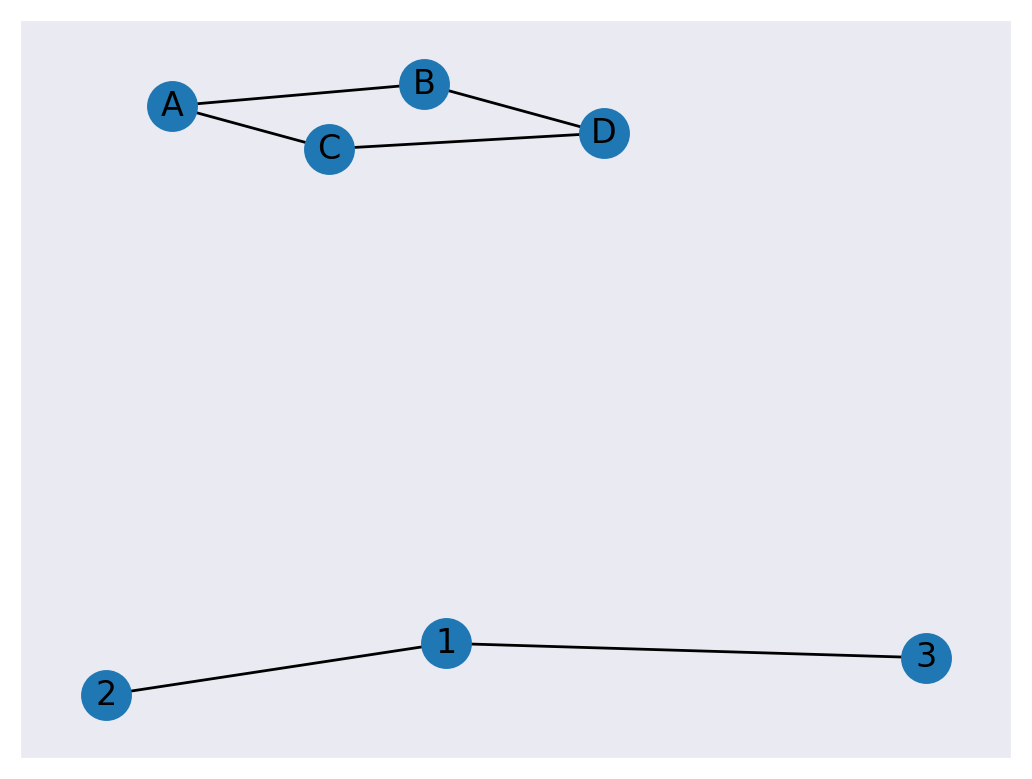

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_edge("A", "B", weight=4)
G.add_edge("B", "D", weight=2)
G.add_edge("A", "C", weight=3)
G.add_edge("C", "D", weight=4)
G.add_edges_from([(1, 2), (1, 3)])
nx.shortest_path(G, "A", "D", weight="weight")
nx.draw_networkx(G)

In [7]:
chord_prog = '|"i""V""i"|"iv""V""i"|"i""VII""III"|"VI""VII""III"|"III"|"VII"|"i"|"iv""II""V"|"V"|"i""V""i"|"III""VII"|"iv""V""i"|]'
match_chords = r'"[^"]*"'
chords = re.findall(match_chords, chord_prog)
chords = [chord.replace('"','') for chord in chords ]
chords

['i',
 'V',
 'i',
 'iv',
 'V',
 'i',
 'i',
 'VII',
 'III',
 'VI',
 'VII',
 'III',
 'III',
 'VII',
 'i',
 'iv',
 'II',
 'V',
 'V',
 'i',
 'V',
 'i',
 'III',
 'VII',
 'iv',
 'V',
 'i']

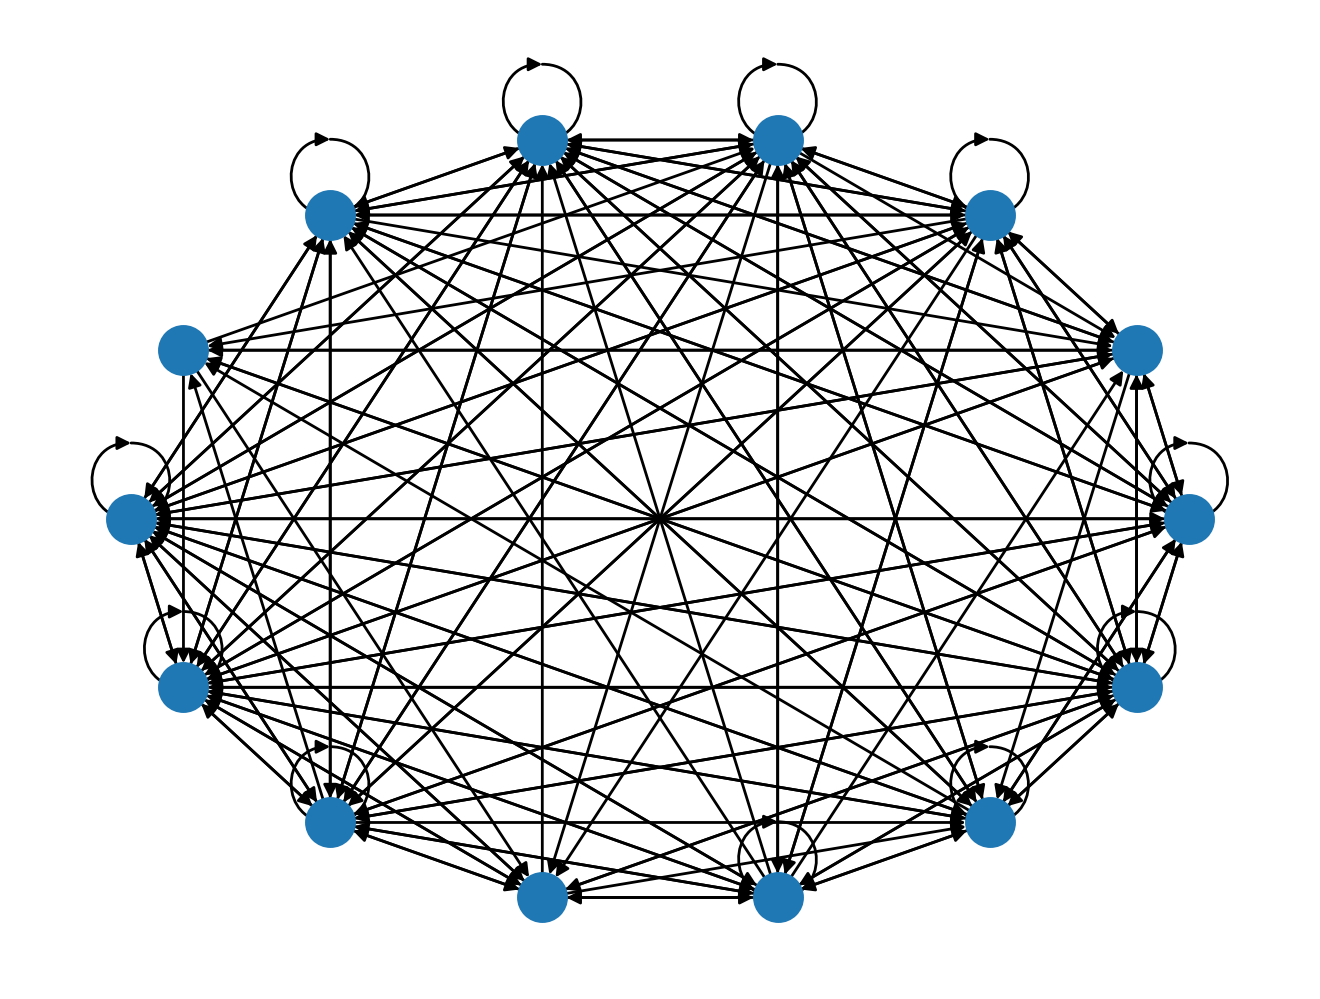

In [9]:
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
def get_pairs_from_chord_prog(chord_prog):
    match_chords = r'"[^"]*"'
    chords = re.findall(match_chords, chord_prog)
    chords = [chord.replace('"','') for chord in chords ]
    chord_prog_pairs = list(zip(chords[:-1],chords[1:]))
    return chord_prog_pairs

chord_prog_count = clean_roman_num_dataset_for_augmentation_df["chord_progression"].apply(get_pairs_from_chord_prog)
chord_prog_count = sum(chord_prog_count.apply(Counter),Counter())
weighted_edges = [(element[0],element[1],count) for element,count in chord_prog_count.items()]
seed = 12345
G = nx.DiGraph()
pos = nx.spring_layout(G, seed=seed)
G.add_weighted_edges_from(weighted_edges)
nx.draw_shell(G)

In [183]:
distance = 1/np.sqrt(G.number_of_nodes())
distance

0.2672612419124244

In [184]:
in_degrees = G.in_degree(weight='weight')
[np.log(in_degrees[node] * 100) for node in G.nodes()]

[13.500525802984484,
 13.166188856944359,
 11.755871643580617,
 9.179881164491475,
 11.307130551990632,
 10.968198289528557,
 12.410644811258948,
 11.11095424611632,
 9.159047077588632,
 10.907789161732996,
 10.437052663271608,
 9.809176873064887,
 9.568014816247999,
 6.396929655216146]

[0.5787370103916867, 0.16866506794564348, 0.5265121236344258, 0.046096456168398615, 0.08979483080202505, 0.5001332267519318, 0.025046629363176125, 0.0021316280309086064, 0.009059419131361577, 0.010391686650679457, 0.0015987210231814548, 0.0061284305888622435, 0.001332267519317879, 1.0, 0.004263256061817213, 0.058353317346123104, 0.021849187316813217, 0.040500932587263526, 0.15001332267519318, 0.051159072741806554, 0.001332267519317879, 0.0045297095656807885, 0.04209965361044498, 0.002398081534772182, 0.0018651745270450307, 0.0005329070077271516, 0.25472954969357847, 0.011990407673860911, 0.0061284305888622435, 0.02664535038635758, 0.0021316280309086064, 0.005329070077271516, 0.02344790833999467, 0.005062616573407941, 0.001332267519317879, 0.0007993605115907274, 0.0005329070077271516, 0.0005329070077271516, 0.0002664535038635758, 0.011990407673860911, 0.006394884092725819, 0.0007993605115907274, 0.002398081534772182, 0.0015987210231814548, 0.0015987210231814548, 0.0007993605115907274, 0

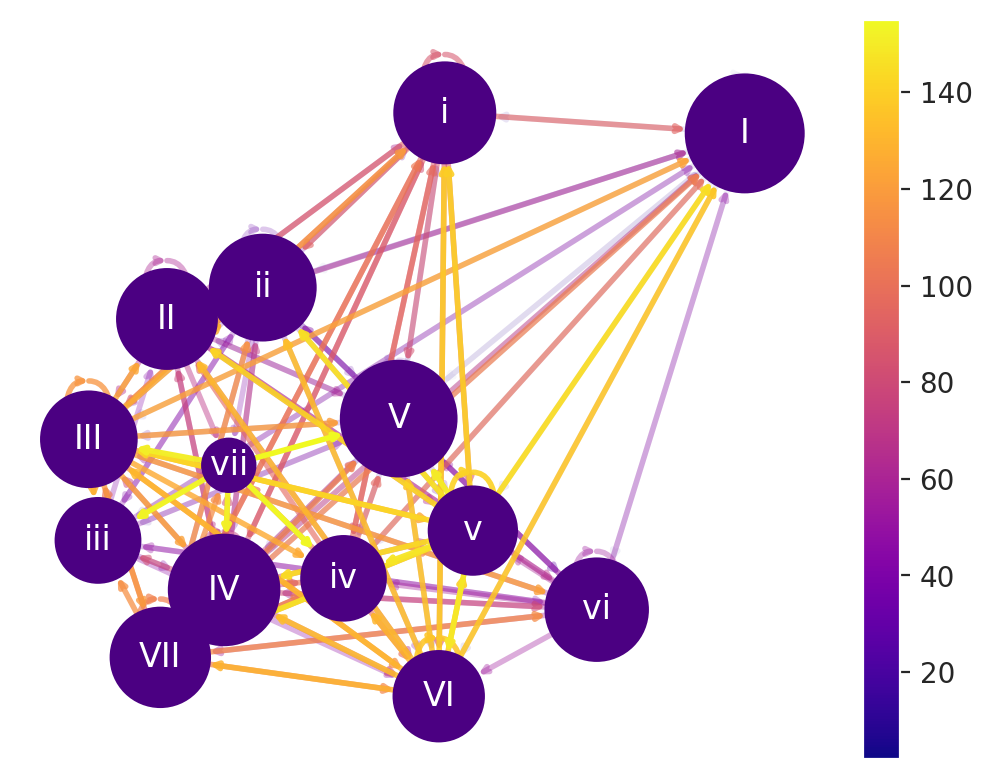

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

seed = 36987  # Seed random number generators for reproducibility
distance = 1/np.sqrt(G.number_of_nodes())
pos = nx.kamada_kawai_layout(G)

in_degrees = G.in_degree(weight='weight')
node_sizes = [np.log(in_degrees[node])*200 for node in G.nodes()]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")


# Normalize edge weights to be between 0 and 1
weights = [d['weight'] for u, v, d in G.edges(data=True)]
max_weight = max(weights)
norm_weights = [w / max_weight for w in weights]

print(norm_weights)

edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=5,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
    alpha=norm_weights
)

# Draw labels with original node names
nx.draw_networkx_labels(G, pos, font_color='white')

# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)

ax = plt.gca()
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
plt.show()

In [172]:
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 7.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [12]:
weights = [d['weight'] for u, v, d in G.edges(data=True)]
max_weight = max(weights)
weights = {(u,v):d['weight']/max_weight for u, v, d in G.edges(data=True)}
weights

{('I', 'V'): 0.5787370103916867,
 ('I', 'ii'): 0.16866506794564348,
 ('I', 'I'): 0.5265121236344258,
 ('I', 'II'): 0.046096456168398615,
 ('I', 'vi'): 0.08979483080202505,
 ('I', 'IV'): 0.5001332267519318,
 ('I', 'VII'): 0.025046629363176125,
 ('I', 'v'): 0.0021316280309086064,
 ('I', 'III'): 0.009059419131361577,
 ('I', 'VI'): 0.010391686650679457,
 ('I', 'iv'): 0.0015987210231814548,
 ('I', 'iii'): 0.0061284305888622435,
 ('I', 'i'): 0.001332267519317879,
 ('V', 'I'): 1.0,
 ('V', 'iii'): 0.004263256061817213,
 ('V', 'IV'): 0.058353317346123104,
 ('V', 'ii'): 0.021849187316813217,
 ('V', 'i'): 0.040500932587263526,
 ('V', 'V'): 0.15001332267519318,
 ('V', 'vi'): 0.051159072741806554,
 ('V', 'iv'): 0.001332267519317879,
 ('V', 'VII'): 0.0045297095656807885,
 ('V', 'II'): 0.04209965361044498,
 ('V', 'VI'): 0.002398081534772182,
 ('V', 'III'): 0.0018651745270450307,
 ('V', 'v'): 0.0005329070077271516,
 ('ii', 'V'): 0.25472954969357847,
 ('ii', 'vi'): 0.011990407673860911,
 ('ii', 'II'): 

In [189]:
dict(G.in_degree(weight='weight'))
dict(G.degree)

{'I': 26,
 'V': 27,
 'ii': 24,
 'iii': 15,
 'vi': 21,
 'II': 22,
 'IV': 28,
 'i': 22,
 'iv': 18,
 'VII': 24,
 'III': 25,
 'VI': 24,
 'v': 22,
 'vii': 10}

In [20]:
from pyvis.network import Network
net = Network(cdn_resources='remote', notebook=True,width="1000px", height="700px", bgcolor='#222222', font_color='white')

G = nx.DiGraph()
pos = nx.kamada_kawai_layout(G)
G.add_weighted_edges_from(weighted_edges)

weights = [d['weight'] for u, v, d in G.edges(data=True)]
max_weight = max(weights)
norm_weights = {(u,v):(d['weight']/max_weight)*30 for u, v, d in G.edges(data=True)}



#node_indegree_weights = dict(G.in_degree(weight='weight'))
node_degree = dict(G.degree)
nx.set_node_attributes(G,node_degree,'size')
nx.set_edge_attributes(G,norm_weights,'weight')
net.from_nx(G)

#net.show_buttons(filter_=['physics'])

net.set_options('''
const options = {
  "physics": {
    "barnesHut": {
      "theta": 0.3,
      "gravitationalConstant": -9800,
      "centralGravity": 2.85,
      "springLength": 255,
      "springConstant": 0.02,
      "damping": 0.03
    },
    "minVelocity": 0.75
  }
}
''')

net.show("chord_prog.html")

chord_prog.html


/tmp/ipykernel_453/273655826.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cmap)


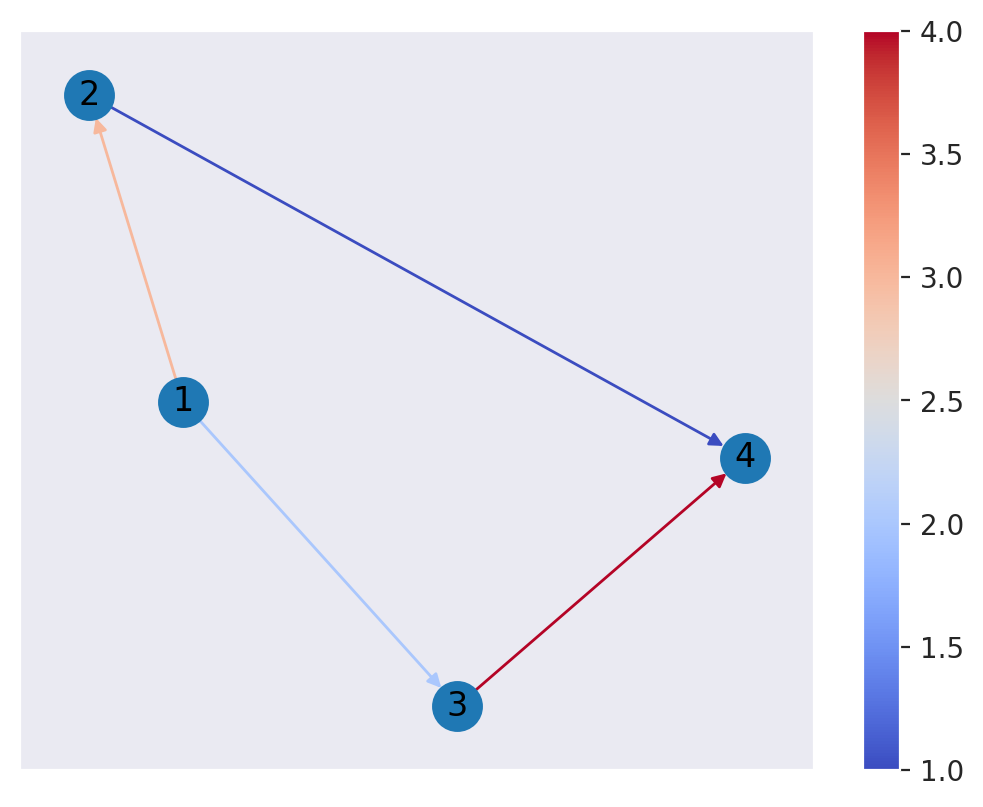

In [102]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

G = nx.DiGraph()
G.add_weighted_edges_from([(1, 2, 3), (1, 3, 2), (2, 4, 1), (3, 4, 4)])
pos = nx.spring_layout(G)

# Get edge weights
weights = [d['weight'] for u, v, d in G.edges(data=True)]

# Normalize edge weights
norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)

# Draw nodes
nx.draw_networkx_nodes(G, pos)

# Draw edges with color gradient based on weight
nx.draw_networkx_edges(G, pos, edge_color=[cmap.to_rgba(w) for w in weights])

# Draw labels
nx.draw_networkx_labels(G, pos)

# Add colorbar
plt.colorbar(cmap)

plt.show()

[('first', 'second', 2), ('third', 'fourth', 1)]
[('first', 'second', {'weight': 2}), ('third', 'fourth', {'weight': 1})]


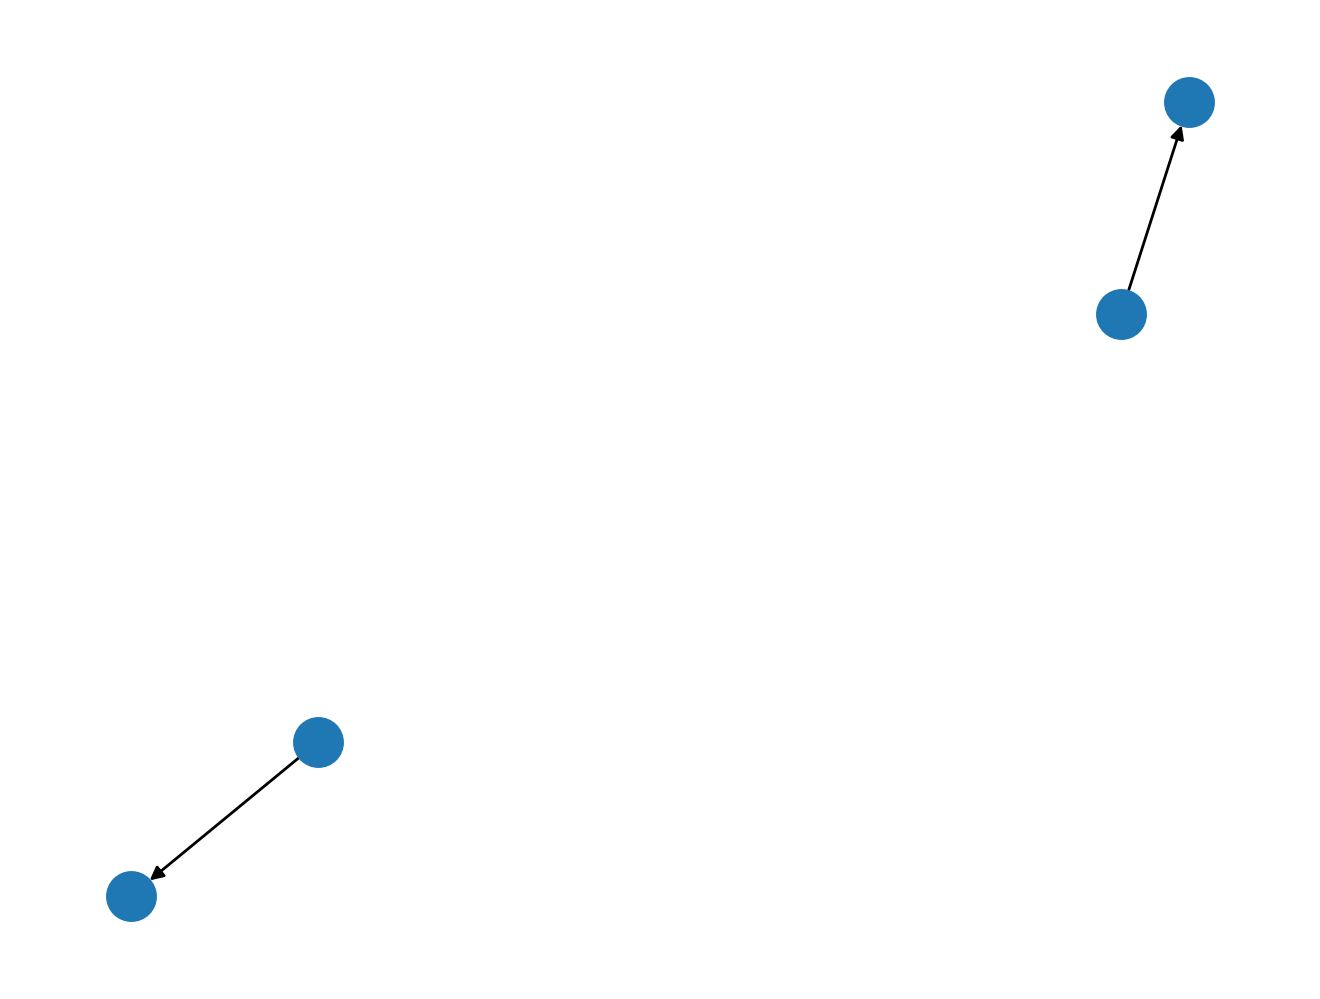

In [59]:
c = Counter([('first', 'second'), ('first', 'second'), ('third', 'fourth')])
my_items = [(element[0],element[1],count) for element,count in c.items()]
print(my_items)
G = nx.DiGraph()
G.add_weighted_edges_from(my_items)

print(G.edges(data=True))

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7) 
nx.draw_networkx_nodes(G, pos, node_size=100)
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)

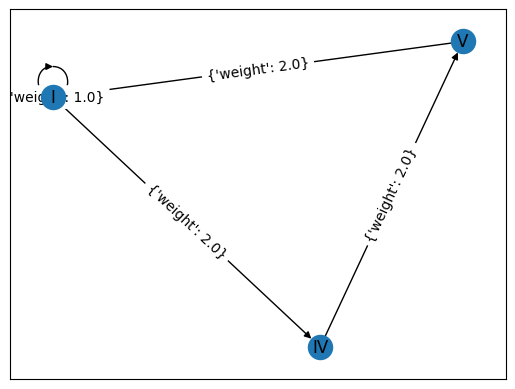

In [84]:
G = nx.DiGraph()
for edge in chord_prog_pairs:
    u, v, w = edge
    if G.has_edge(u, v):
        G[u][v]['weight'] += w
    else:
        G.add_edge(u, v, weight=w)
        
nx.set_node_attributes(G, {node: str(node) for node in G.nodes}, 'label')
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edge_labels(G, pos)
nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'))
plt.show()

## Augmented Roman Numeral Dataset EDA

In [2]:
augmented_roman_num_dataset_relative_path = "notebooks/data/augmented_roman_num_dataset"
songs_roman_num_df_augmented, clean_roman_num_songs_augmented_df ,chords_roman_num_occurrences_aug= prepare_dataset_for_EDA(relative_path=augmented_roman_num_dataset_relative_path,drop_by_occurrences=True,drop_occur_threshold=20, drop_by_extended_chord=True, drop_more_than_one_voice=True)
clean_roman_num_songs_augmented_df

number of values to be dropped:
 False    9732
dtype: int64
number chords least occurrences:  0
chords least occurrences []
number of values to be dropped:
 False    9732
dtype: int64
Number of dropped songs with more than one voice: 228
******************************


,reference_number,title,meter,unit_note_length,key,tuneBook,original_header,original_body,"""I""","""V""",...,"""IV""",clean_body,"""i""","""iv""","""VII""","""III""","""VI""","""v""","""vii""",chord_progression
0,6,The Indian Queen,4/4,1/4,Ab,dataset_6.abc,X:6\nT:The Indian Queen\nM:4/4\nL:1/4\nK:Abmajor,"c'/2d'/2|""I""e'c'ac'|""V""b2e2|""I""ceec'|""ii""b2-""V...",7,8,...,2,"c'/2d'/2|""I""e'c'ac'|""V""b2e2|""I""ceec'|""ii""b2-""V...",0,0,0,0,0,0,0,"|""I""|""V""|""I""|""ii""""V""|""I""|""V""|""I""|""I""|""V""|""iii""..."
1,7,Mr Beveridge's Maggot,3/2,1/8,C#m,dataset_6.abc,X:7\nT:Mr Beveridge's Maggot\nM:3/2\nL:1/8\nK:...,"""i""c'4""V""^b2^ab""i""c'4|""iv""g2fe""V""def2""i""e2c2|""...",0,6,...,0,"""i""c'4""V""^b2^ab""i""c'4|""iv""g2fe""V""def2""i""e2c2|""...",8,3,4,4,1,0,0,"|""i""""V""""i""|""iv""""V""""i""|""i""""VII""""III""|""VI""""VII""""..."
2,8,Nancy's Fancy,4/4,1/4,Db,dataset_6.abc,X:8\nT:Nancy's Fancy\nM:4/4\nL:1/4\nK:Dbmajor,"|A|""I""dffe/2f/2|""V""geea|""I""fddf|""ii""e/2d/2c/2B...",10,8,...,0,"|A|""I""dffe/2f/2|""V""geea|""I""fddf|""ii""e/2d/2c/2B...",0,0,0,0,0,0,0,"|""I""|""V""|""I""|""ii""""V""|""I""""vi""|""ii""""V""|""I""""V""|""I..."
3,9,Never Love Thee More,6/8,1/8,Db,dataset_6.abc,X:9\nT:Never Love Thee More\nM:6/8\nL:1/8\nK:D...,"""I""ABAd2e|""I""fgfe2d|""I""af2e2d|""IV""B3-B3|""I""ABA...",11,2,...,5,"""I""ABAd2e|""I""fgfe2d|""I""af2e2d|""IV""B3-B3|""I""ABA...",0,0,0,0,0,0,0,"|""I""|""I""|""I""|""IV""|""I""|""I""|""I""|""IV""|""I""|""IV""|""I..."
4,10,Nonesuch,4/4,1/4,G#m,dataset_6.abc,X:10\nT:Nonesuch\nM:4/4\nL:1/4\nK:G#minor,"d'|""i""d'bc'd'|""i""ba/2b/2gd'|""i""d'bc'd'|""i""b2bd...",0,0,...,0,"d'|""i""d'bc'd'|""i""ba/2b/2gd'|""i""d'bc'd'|""i""b2bd...",10,0,2,2,0,2,0,"|""i""|""i""|""i""|""i""|""III""|""i""|""III""|""i""|""VII""|""i""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9499,78,Grandpa's,4/4,1/4,A,dataset_min5.abc,X:78\nT:Grandpa's\nM:4/4\nL:1/4\nK:Amajor,"E/2D/2|""I""CE""V""FG|""I""A/2G/2A/2B/2ce|""ii""dc""II""...",9,9,...,2,"E/2D/2|""I""CE""V""FG|""I""A/2G/2A/2B/2ce|""ii""dc""II""...",0,0,0,0,0,0,0,"|""I""""V""|""I""|""ii""""II""|""V""|""I""""V""|""I""|""ii""""V""|""I..."
9500,79,The Girl With The Green Hat On,4/4,1/4,A,dataset_min5.abc,X:79\nT:The Girl With The Green Hat On\nM:4/4\...,"(3E/2F/2G/2|""I""AE""V""E/2F/2E/2D/2|""I""C/2D/2E/2F...",9,8,...,0,"(3E/2F/2G/2|""I""AE""V""E/2F/2E/2D/2|""I""C/2D/2E/2F...",0,0,0,0,0,0,0,"|""I""""V""|""I""""V""|""I""|""V""|""I""""V""|""I""|""II""""V""|""I""|..."
9501,80,Green Meadow,4/4,1/4,D,dataset_min5.abc,X:80\nT:Green Meadow\nM:4/4\nL:1/4\nK:Dmajor,"(3A,/2B,/2C/2|""I""DD/2E/2F/2D/2F/2A/2|""IV""B/2c/...",10,7,...,6,"(3A,/2B,/2C/2|""I""DD/2E/2F/2D/2F/2A/2|""IV""B/2c/...",0,0,0,0,0,0,0,"|""I""|""IV""""I""|""ii""|""ii""""V""|""I""|""IV""""I""|""IV""|""V""..."
9502,82,The Old Grey Cat,4/4,1/4,Bm,dataset_min5.abc,X:82\nT:The Old Grey Cat\nM:4/4\nL:1/4\nK:Bminor,"F|""i""BBB,B,/2C/2|""i""D/2C/2D/2E/2F/2E/2F/2^G/2|...",0,3,...,0,"F|""i""BBB,B,/2C/2|""i""D/2C/2D/2E/2F/2E/2F/2^G/2|...",10,1,5,0,0,0,0,"|""i""|""i""|""VII""|""VII""|""i""|""i""|""V""|""i""|""i""|""i""|""..."


In [3]:
chords_roman_num_occurrences_aug.sort_values(by="count",ascending=False).iloc[-40:]

,chords,count
13,"""I""",95616
12,"""V""",63132
11,"""IV""",29508
10,"""ii""",15408
9,"""vi""",9912
8,"""i""",8844
7,"""II""",6960
6,"""VII""",6564
5,"""III""",4104
4,"""VI""",2232


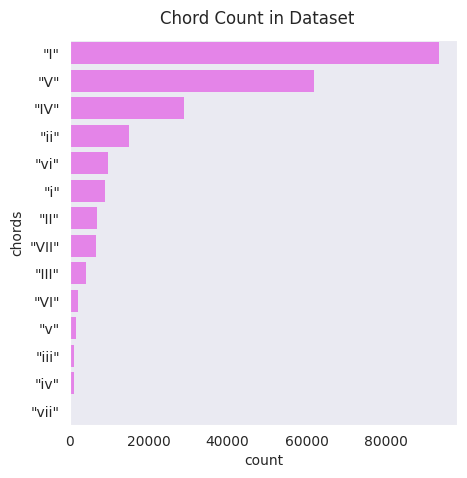

In [4]:
def get_chord_bar_plot(new_df):
    fig, ax1, = plt.subplots(1, 1, figsize=(5, 5),sharex=True)
    

    clean_songs_augmented_df= new_df
    chords_names_aug = clean_songs_augmented_df.columns[clean_songs_augmented_df.columns.str.contains('"[^"]*"')]

    chords_aug_occurrences_df = clean_songs_augmented_df[chords_names_aug].sum().sort_values(ascending=False).reset_index()
    column_names = {
        'index': 'chords',
        0:'count'
        }
    chords_aug_occurrences_df = chords_aug_occurrences_df.rename(columns=column_names)
    sns.barplot(ax=ax1,data=chords_aug_occurrences_df,y="chords", x="count",edgecolor='none',color="magenta",alpha=0.5)

    fig.suptitle('Chord Count in Dataset', y=0.94)

get_chord_bar_plot(clean_roman_num_songs_augmented_df)  

In [5]:
chord_prog= '|"I"|"V"|"I"|"ii""V"|"I"|"V"|"I"|"I"|"V"|'
re.findall(r'\"(.*?)\"',chord_prog)

['I', 'V', 'I', 'ii', 'V', 'I', 'V', 'I', 'I', 'V']

In [6]:
extract_chords_only = lambda chord_prog: re.findall(r'\"(.*?)\"',chord_prog)
major_or_minor = lambda x: 'Minor Key' if 'm' in x  else 'Major Key'

In [7]:
clean_roman_num_songs_augmented_df["chord_prog_lists"] = clean_roman_num_songs_augmented_df.chord_progression.apply(extract_chords_only)
clean_roman_num_songs_augmented_df["key_mode"] = clean_roman_num_songs_augmented_df.key.apply(major_or_minor)

In [8]:
roman_num_cols = ['"I"', '"V"', '"ii"',
       '"iii"', '"vi"', '"II"', '"IV"','"i"', '"iv"', '"VII"',
       '"III"', '"VI"', '"v"', '"vii"','key_mode']
chord_prog_data_df = clean_roman_num_songs_augmented_df[roman_num_cols]

In [10]:
chord_prog_data_df

,"""I""","""V""","""ii""","""iii""","""vi""","""II""","""IV""","""i""","""iv""","""VII""","""III""","""VI""","""v""","""vii""",key_mode
0,7,8,2,1,1,1,2,0,0,0,0,0,0,0,Major Key
1,0,6,0,0,0,1,0,8,3,4,4,1,0,0,Minor Key
2,10,8,4,0,5,0,0,0,0,0,0,0,0,0,Major Key
3,11,2,2,0,0,0,5,0,0,0,0,0,0,0,Major Key
4,0,0,0,0,0,0,0,10,0,2,2,0,2,0,Minor Key
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9499,9,9,3,0,0,2,2,0,0,0,0,0,0,0,Major Key
9500,9,8,2,0,0,1,0,0,0,0,0,0,0,0,Major Key
9501,10,7,4,0,0,0,6,0,0,0,0,0,0,0,Major Key
9502,0,3,0,0,0,0,0,10,1,5,0,0,0,0,Minor Key


In [9]:
result_log = chord_prog_data_df.groupby('key_mode').sum().T.sort_values("Major Key", ascending=False).apply(np.log).reset_index()
result = chord_prog_data_df.groupby('key_mode').sum().T.sort_values("Major Key", ascending=False).reset_index()
print(result_log)

key_mode  index  Major Key  Minor Key
0           "I"  11.443061   5.480639
1           "V"  10.997690   7.638198
2          "IV"  10.249203   6.492240
3          "ii"   9.614204   4.564348
4          "vi"   9.176990   2.484907
5          "II"   8.802071   5.192957
6         "VII"   7.737180   8.354204
7         "III"   7.547502   7.643962
8          "VI"   7.221105   6.674561
9         "iii"   7.049255       -inf
10          "v"   6.246107   7.059618
11         "iv"   5.918894   6.643790
12          "i"   5.123964   9.068316
13        "vii"   3.583519   3.178054


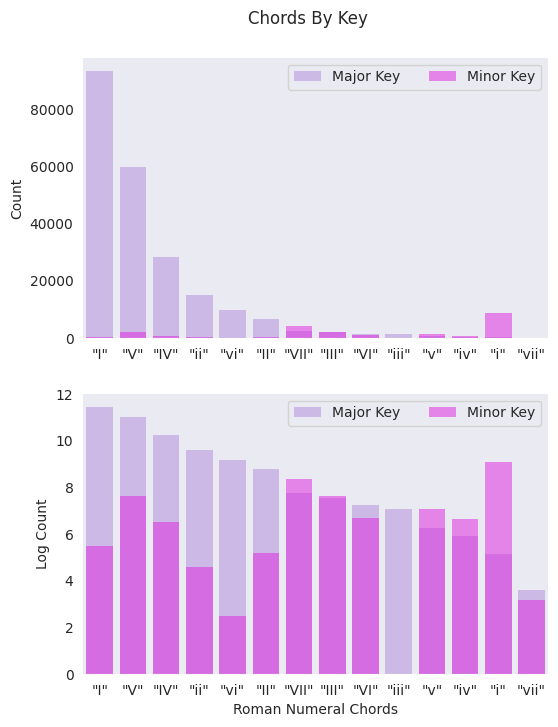

In [10]:
# Initialize the matplotlib figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# Plot the total crashes
sns.barplot(ax=ax1,y="Major Key", x="index", data=result,
            label="Major Key",edgecolor='None', color='#8D34DC',alpha=0.3)

# Plot the crashes where alcohol was involved
sns.barplot(ax=ax1,y="Minor Key", x="index", data=result,
            label="Minor Key",edgecolor='None', color='magenta',alpha=0.5)

# Add a legend and informative axis label
ax1.legend(ncol=2, loc="upper right", frameon=True)
ax1.set(ylabel="Count",
       xlabel="")
fig.suptitle('Chords By Key', y=0.94)
sns.despine(left=True, top=True)


# Plot the total crashes
sns.barplot(ax=ax2,y="Major Key", x="index", data=result_log,
            label="Major Key",edgecolor='None', color='#8D34DC',alpha=0.3)

# Plot the crashes where alcohol was involved
sns.barplot(ax=ax2,y="Minor Key", x="index", data=result_log,
            label="Minor Key",edgecolor='None', color='magenta',alpha=0.5)
# Add a legend and informative axis label
ax2.legend(ncol=2, loc="upper right", frameon=True)
ax2.set(ylabel="Log Count",
       xlabel="Roman Numeral Chords")
fig.suptitle('Chords By Key', y=0.94)
sns.despine(left=True, top=True)


In [11]:
df = chord_prog_data_df.groupby('key_mode').sum().T.sort_values("Major Key", ascending=False)
df

key_mode,Major Key,Minor Key
"""I""",93252,240
"""V""",59736,2076
"""IV""",28260,660
"""ii""",14976,96
"""vi""",9672,12
"""II""",6648,180
"""VII""",2292,4248
"""III""",1896,2088
"""VI""",1368,792
"""iii""",1152,0


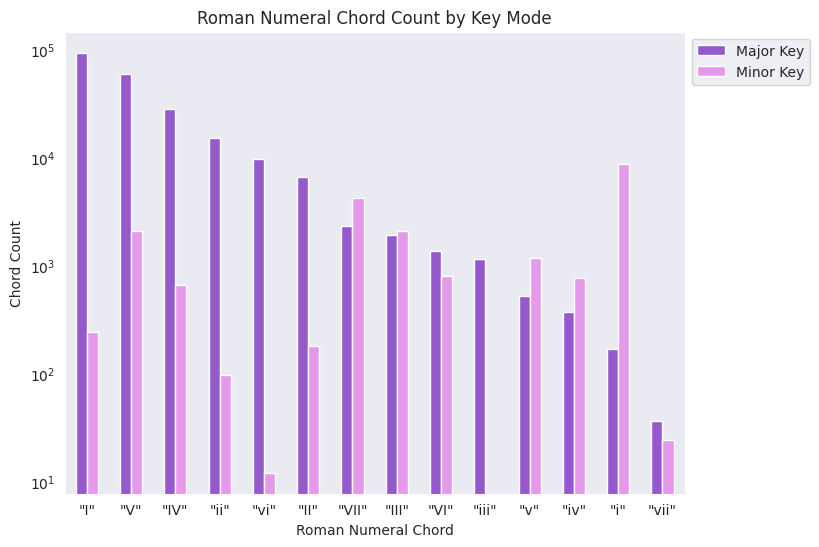

In [12]:
colors = ['#9559CB','#E599EA']
alphas = [0.9, 0.4]
ax = df.plot(kind='bar', logy=True, figsize=(8, 6), rot=0,color=colors)
ax.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_title("Roman Numeral Chord Count by Key Mode")
ax.set_xlabel("Roman Numeral Chord")
ax.set_ylabel("Chord Count")
plt.show()

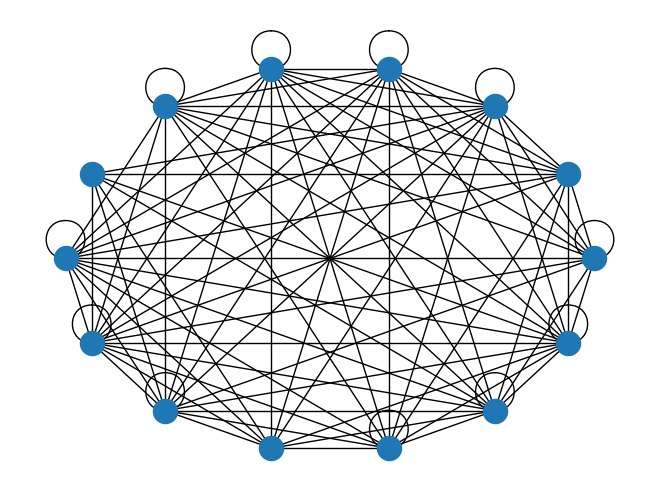

In [28]:
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
def get_pairs_from_chord_prog(chord_prog):
    match_chords = r'"[^"]*"'
    chords = re.findall(match_chords, chord_prog)
    chords = [chord.replace('"','') for chord in chords ]
    chord_prog_pairs = list(zip(chords[:-1],chords[1:]))
    return chord_prog_pairs

chord_prog_count = clean_roman_num_songs_augmented_df["chord_progression"].apply(get_pairs_from_chord_prog)
chord_prog_count = sum(chord_prog_count.apply(Counter),Counter())
weighted_edges = [(element[0],element[1],count) for element,count in chord_prog_count.items()]
seed = 12345
G = nx.Graph()
pos = nx.spring_layout(G, seed=seed)
G.add_weighted_edges_from(weighted_edges)
nx.draw_shell(G)

In [8]:
my_nodes =  {'I': 1,
 'V': 2,
 'ii': 2,
 'iii': 2,
 'vi': 0,
 'II': 0,
 'IV': 2,
 'i': 1,
 'iv': 0,
 'VII': 2,
 'III': 3,
 'VI': 0,
 'v': 0,
 'vii': 2}

major_degrees = {'I',
'ii',
'iii',
'IV',
'V',
'vi',
'vii'}
minor_degrees={
'i',
'ii',
'III',
'iv',
'v',
'VI',
'VII'
}

my_nodes_by_tone = {degree:'0' if degree in major_degrees else '1' for degree in my_nodes}
my_nodes_by_tone

{'I': '0',
 'V': '0',
 'ii': '0',
 'iii': '0',
 'vi': '0',
 'II': '1',
 'IV': '0',
 'i': '1',
 'iv': '1',
 'VII': '1',
 'III': '1',
 'VI': '1',
 'v': '1',
 'vii': '0'}

In [9]:
my_nodes_colors = {degree:'#330a1c' if degree in major_degrees else '#811A48' for degree in my_nodes}
my_nodes_colors

{'I': '#330a1c',
 'V': '#330a1c',
 'ii': '#330a1c',
 'iii': '#330a1c',
 'vi': '#330a1c',
 'II': '#811A48',
 'IV': '#330a1c',
 'i': '#811A48',
 'iv': '#811A48',
 'VII': '#811A48',
 'III': '#811A48',
 'VI': '#811A48',
 'v': '#811A48',
 'vii': '#330a1c'}

In [30]:
weights = [d['weight'] for u, v, d in G.edges(data=True)]
np.ceil(np.log(weights))

array([11.,  7., 11.,  9.,  5., 10.,  7.,  5.,  5.,  4.,  5.,  5.,  4.,
        7.,  5.,  8.,  9.,  8.,  5.,  9.,  8.,  5.,  6.,  5.,  3.,  3.,
        7.,  6.,  6.,  8.,  5.,  4.,  4.,  4.,  4.,  4.,  3.,  7.,  3.,
        4.,  4.,  4.,  3.,  3.,  5.,  7.,  7.,  7.,  4.,  4.,  4.,  3.,
        4.,  5.,  7.,  5.,  4.,  5.,  4.,  3.,  7.,  8.,  6.,  6.,  3.,
        5.,  3.,  3.,  6.,  8.,  8.,  6.,  7.,  4.,  5.,  3.,  3.,  5.,
        3.,  7.,  5.,  7.,  5.,  3.,  6.,  6.,  4.,  6.,  4.,  6.])

In [52]:
from pyvis.network import Network
net = Network(cdn_resources='remote', notebook=True,width="1000px", height="700px", bgcolor='#222222', font_color='white')
seed = 1212
G = nx.Graph()
pos = nx.kamada_kawai_layout(G)
G.add_weighted_edges_from(weighted_edges)

weights = [d['weight'] for u, v, d in G.edges(data=True)]
max_weight = max(weights)
norm_weights = {(u,v):(d['weight']/max_weight)*25 for u, v, d in G.edges(data=True)}



#node_indegree_weights = dict(G.in_degree(weight='weight'))
node_degree = dict(G.degree)
nx.set_node_attributes(G,node_degree,'size')
nx.set_edge_attributes(G,norm_weights,'weight')
nx.set_node_attributes(G,my_nodes_by_tone,'group')
net.from_nx(G)

#net.show_buttons(filter_=['physics'])


net.set_options('''
const options = {
  "physics": {
    "repulsion": {
      "springLength": 330,
      "springConstant": 0.235,
      "nodeDistance": 320
    },
    "minVelocity": 0.75,
    "solver": "repulsion"
  }
}
''')

net.show("chord_prog.html")

chord_prog.html


## Save Roman Numeral Dataset for Training

In [20]:
#clean_dataset_for_augmentation_df = generate_clean_songs(clean_songs_augmented_df,for_training=False)
print("dataset shape",clean_roman_num_songs_augmented_df.shape)
print("dataset\n",clean_roman_num_songs_augmented_df.columns.sort_values(ascending=False))

clean_augmented_roman_num_dataset_for_training_df = generate_clean_songs(clean_roman_num_songs_augmented_df,for_training=True)

relative_path ="notebooks/data/final_dataset"
filename_name = 'clean_augmented_roman_num_data'
save_dataframe(df=clean_augmented_roman_num_dataset_for_training_df,file_name=filename_name,relative_path=relative_path)
write_tuneBook_file(clean_augmented_roman_num_dataset_for_training_df,relative_path,filename_name)

dataset shape (9504, 28)
dataset
 Index(['unit_note_length', 'tuneBook', 'title', 'reference_number',
       'original_header', 'original_body', 'meter', 'key_mode', 'key',
       'clean_song', 'clean_header', 'clean_body', 'chord_progression',
       'chord_prog_lists', '"vii"', '"vi"', '"v"', '"iv"', '"iii"', '"ii"',
       '"i"', '"VII"', '"VI"', '"V"', '"IV"', '"III"', '"II"', '"I"'],
      dtype='object')
clean_augmented_roman_num_data  dataset shape (9504, 28)
Index(['unit_note_length', 'tuneBook', 'title', 'reference_number',
       'original_header', 'original_body', 'meter', 'key_mode', 'key',
       'clean_song', 'clean_header', 'clean_body', 'chord_progression',
       'chord_prog_lists', '"vii"', '"vi"', '"v"', '"iv"', '"iii"', '"ii"',
       '"i"', '"VII"', '"VI"', '"V"', '"IV"', '"III"', '"II"', '"I"'],
      dtype='object')
----------
